# biocharStability - Exploratory Data Analysis

The goal of this notebook is to perform the EDA of the biochar decomposition dataset. It is structured as follow:

1. Analysis of decomposition data
2. Analysis of experimental metadata
3. Analysis of correlation in dataset (Pearson, Distance correlation, PCA)

In [225]:
import biocharStability as bs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from adjustText import adjust_text
import ternary as ter
sns.set_style('ticks')
import string
import geopandas as gpd
import itertools
import dcor as dc


In [226]:
fp = '../biocharStability/database/biochar_incubation_database_2022-03-22_live.xlsx'
metadata, schema, metadata_column_sets = bs.load_metadata(filepath=fp)
data = bs.load_data(filepath=fp)
articles = bs.load_articles(filepath=fp)
validation = bs.load_validation(filepath=fp)

Metadata loaded, with 187 rows
Data loaded, with 2941 rows
Articles loaded, with 76 rows
Validation loaded, with 151 rows


In [21]:
bs.print_database_completion_stats(articles, data, metadata, validation, schema)

** Completion statistics **
	** table: articles **
Number of data cells : 1080 ( 100.0 % )
Number of cells with 'available' information : 743 ( 68.8 % )
Number of cells with 'not available' information : 0 ( 0.0 % )
Number of empty cells (NaN) : 337 ( 31.2 % )
	** table: data **
Number of data cells : 73632 ( 100.0 % )
Number of cells with 'available' information : 24281 ( 33.0 % )
Number of cells with 'not available' information : 0 ( 0.0 % )
Number of empty cells (NaN) : 49351 ( 67.0 % )
	** table: metadata **
Number of data cells : 11200 ( 100.0 % )
Number of cells with 'available' information : 6884 ( 61.5 % )
Number of cells with 'not available' information : 2185 ( 19.5 % )
Number of empty cells (NaN) : 2131 ( 19.0 % )
	** table: validation **
Number of data cells : 13589 ( 100.0 % )
Number of cells with 'available' information : 2976 ( 21.9 % )
Number of cells with 'not available' information : 2488 ( 18.3 % )
Number of empty cells (NaN) : 8125 ( 59.8 % )

** Number of articles 

NOTE: the following ID_obs correspond to dried raw biomass incubated.
- 49 (corncob, Budai2016)
- 56 (miscanthus, Budai2016)
- 169 (pine, topsoil, Santos2021)
- 170 (pine, subsoil, Santos2021)

[49, 56, 169, 170]

## Decomposition data

In [6]:
out, bins = pd.qcut(metadata['IncubationDuration'], q=4, retbins=True, duplicates='drop')
bins, out.value_counts()

(array([  90.,  365.,  368.,  730., 3102.]),
 (89.999, 365.0]    67
 (368.0, 730.0]     40
 (730.0, 3102.0]    31
 (365.0, 368.0]      5
 Name: IncubationDuration, dtype: int64)

In [5]:
months_cutoffs, sets_incubations, sets_labels = bs.classify_observations_by_duration(metadata, months_cutoffs=[30, 20, 12, 0])

Incubation longer than 30 months --->  17  observations
Incubation longer than 20 months --->  38  observations
Incubation longer than 12 months --->  15  observations
Incubation longer than 0 months --->  58  observations


Incubation longer than 30 months --->  17  observations
Incubation longer than 20 months --->  38  observations
Incubation longer than 12 months --->  15  observations
Incubation longer than 0 months --->  58  observations


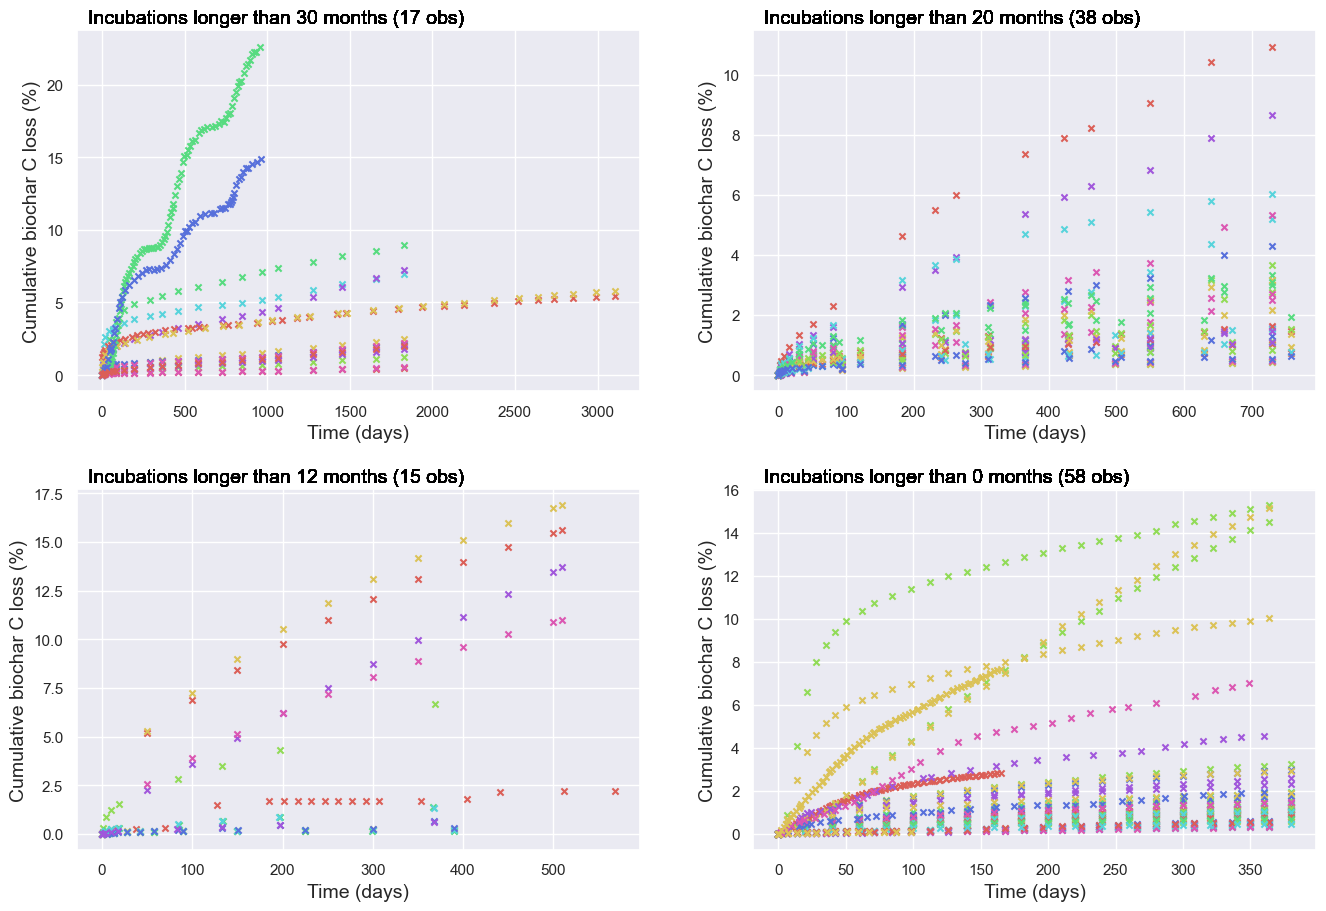

In [6]:
# plot raw cumulative C loss, in 4 subplots
months_cutoffs, sets_incubations, sets_labels = bs.classify_observations_by_duration(metadata)

fig, axes, axl = bs.plot_timeseries_by_group(data, metadata, sets_incubations, 'C_bc_loss_rel', titles=sets_labels,
                                             ylabel="Cumulative biochar C loss (%)", factor=100,
                                             saveFig=False)

#[axl[i].set_yscale('log') for i in range(len(axl))] # y-log scale
#[axl[i].set_xscale('log') for i in range(len(axl))] # x-log scale

plt.show()

### Fig. Decay rates timeseries, log-scale

Incubation longer than 0 months --->  143  observations


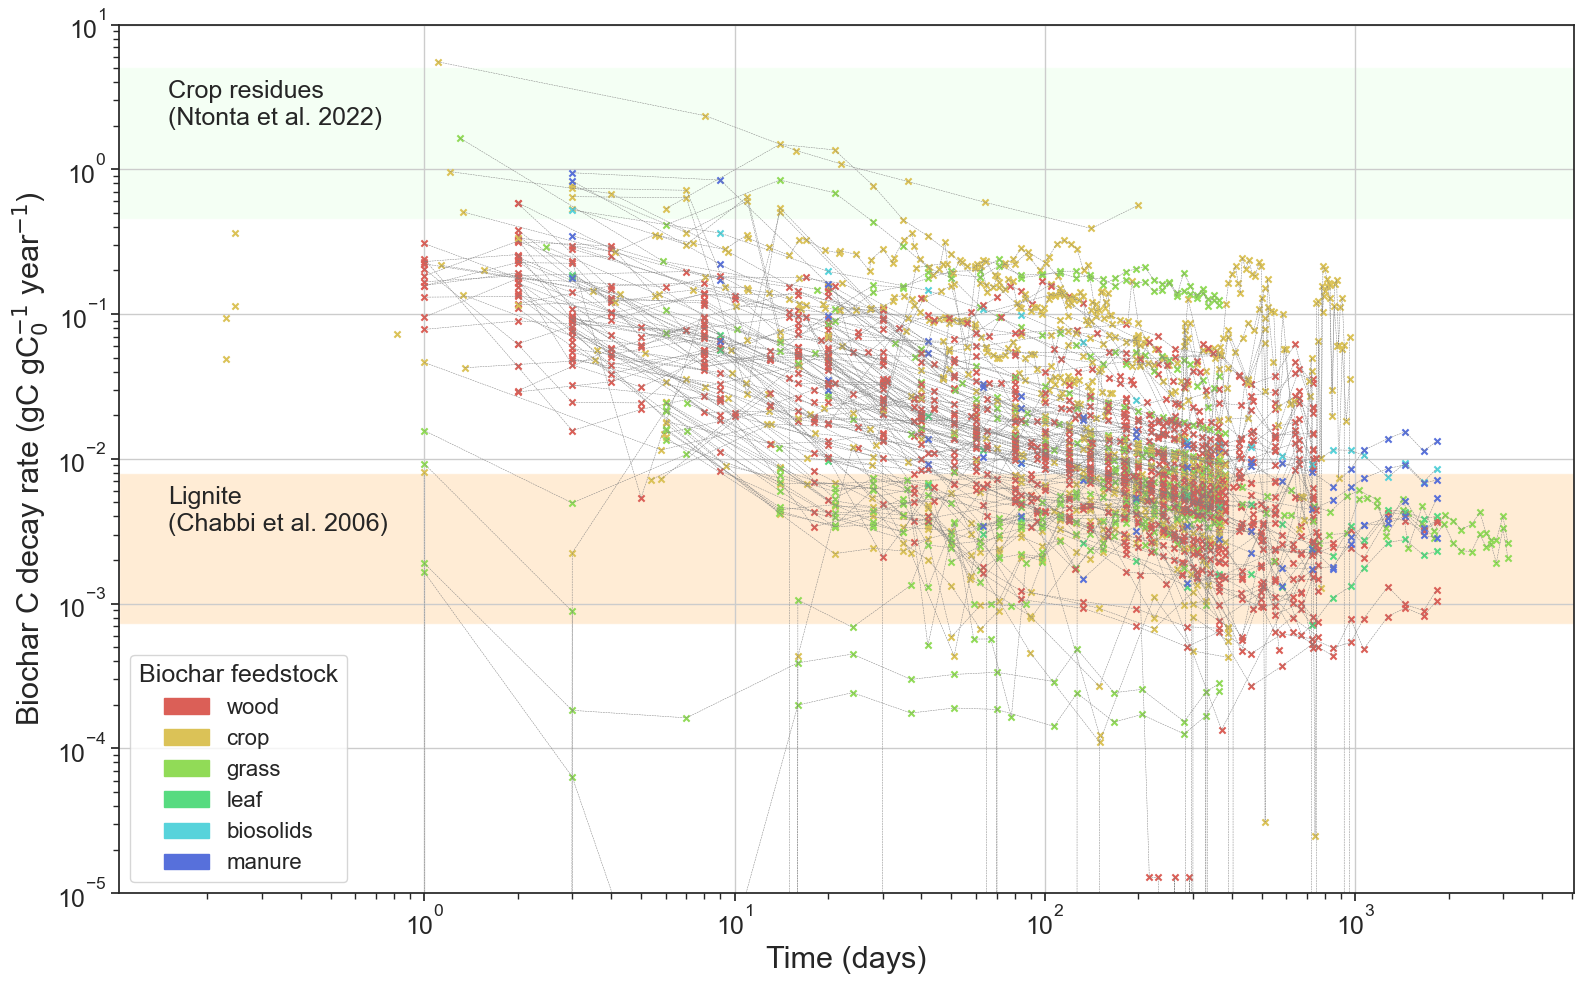

In [10]:
# plot raw decay rates, in 1 subplot, log scale y and x
# yearly
# without raw-biomass in dataset
yearly = 365
months_cutoffs, sets_incubations, sets_labels = bs.classify_observations_by_duration(metadata, months_cutoffs=[0])

fig, axes, axl = bs.plot_timeseries_by_group(data, metadata, sets_incubations, 'k_bc_reld', titles=[''],
                                             ylabel=r"Biochar C decay rate (gC/gC$_{0}$/year)", factor=yearly,
                                             line=True, lw=0.35,
                                             exclude_obs=[49, 56, 169, 170],
                                             color_list='BiomassClass', legend_title='Biochar feedstock',
                                             nrows=1, ncols=1, saveFig=False)

[axl[i].set_yscale('log') for i in range(len(axl))] # y-log scale
[axl[i].set_xscale('log') for i in range(len(axl))] # x-log scale

[axl[i].set_xlabel(xlabel="Time (days)", fontsize=22) for i in range(len(axl))] # label and size
[axl[i].set_ylabel(ylabel=r"Biochar C decay rate (gC gC$_{0}^{-1}$ year$^{-1}$)", fontsize=22) for i in range(len(axl))] # label and size
#[axl[i].get_legend().remove() for i in range(len(axl))]

# add range decay rates of raw crop residue, from Ntonta2022
low_value = 1.24e-3*yearly # 4e-3*yearly # gCO2-C per gC added per year
high_value = 1.4e-2*yearly # 1.1e-2*yearly # gCO2-C per gC added per year
annotation_text = 'Crop residues\n(Ntonta et al. 2022)'
axl[0].axhspan(low_value, high_value, facecolor='honeydew', alpha=0.7, zorder=-100)

# Add text annotation within the shaded area
x_pos = 0.15
y_pos = (low_value + high_value) / 2
plt.text(x_pos, y_pos, annotation_text, ha='left', va='center', fontsize=18)

# add range decay rates of lignite, in diff redox conditions, after 450 days, from Chabbi2006
low_value = 1.97e-6*yearly # gCO2-C per gC added per year
high_value = 2.2e-5*yearly # gCO2-C per gC added per year
annotation_text = 'Lignite\n(Chabbi et al. 2006)'
axl[0].axhspan(low_value, high_value, facecolor='bisque', alpha=0.7, zorder=-100)
# Add text annotation within the shaded area
y_pos = (low_value + high_value) / 2
plt.text(x_pos, y_pos, annotation_text, ha='left', va='center', fontsize=18)

# tickparams
axl[0].tick_params(labelsize=18)
axl[0].grid(axis='both')
axl[0].set_ylim([1e-5, 1e1]) # ylim in log-scale

fig.tight_layout()
plt.savefig("../simulations/manuscript/FigureS5_timeseries_yearly_decay_rates_logscale2_annotated.png", dpi=600)
plt.show()


Incubation longer than 0 months --->  143  observations


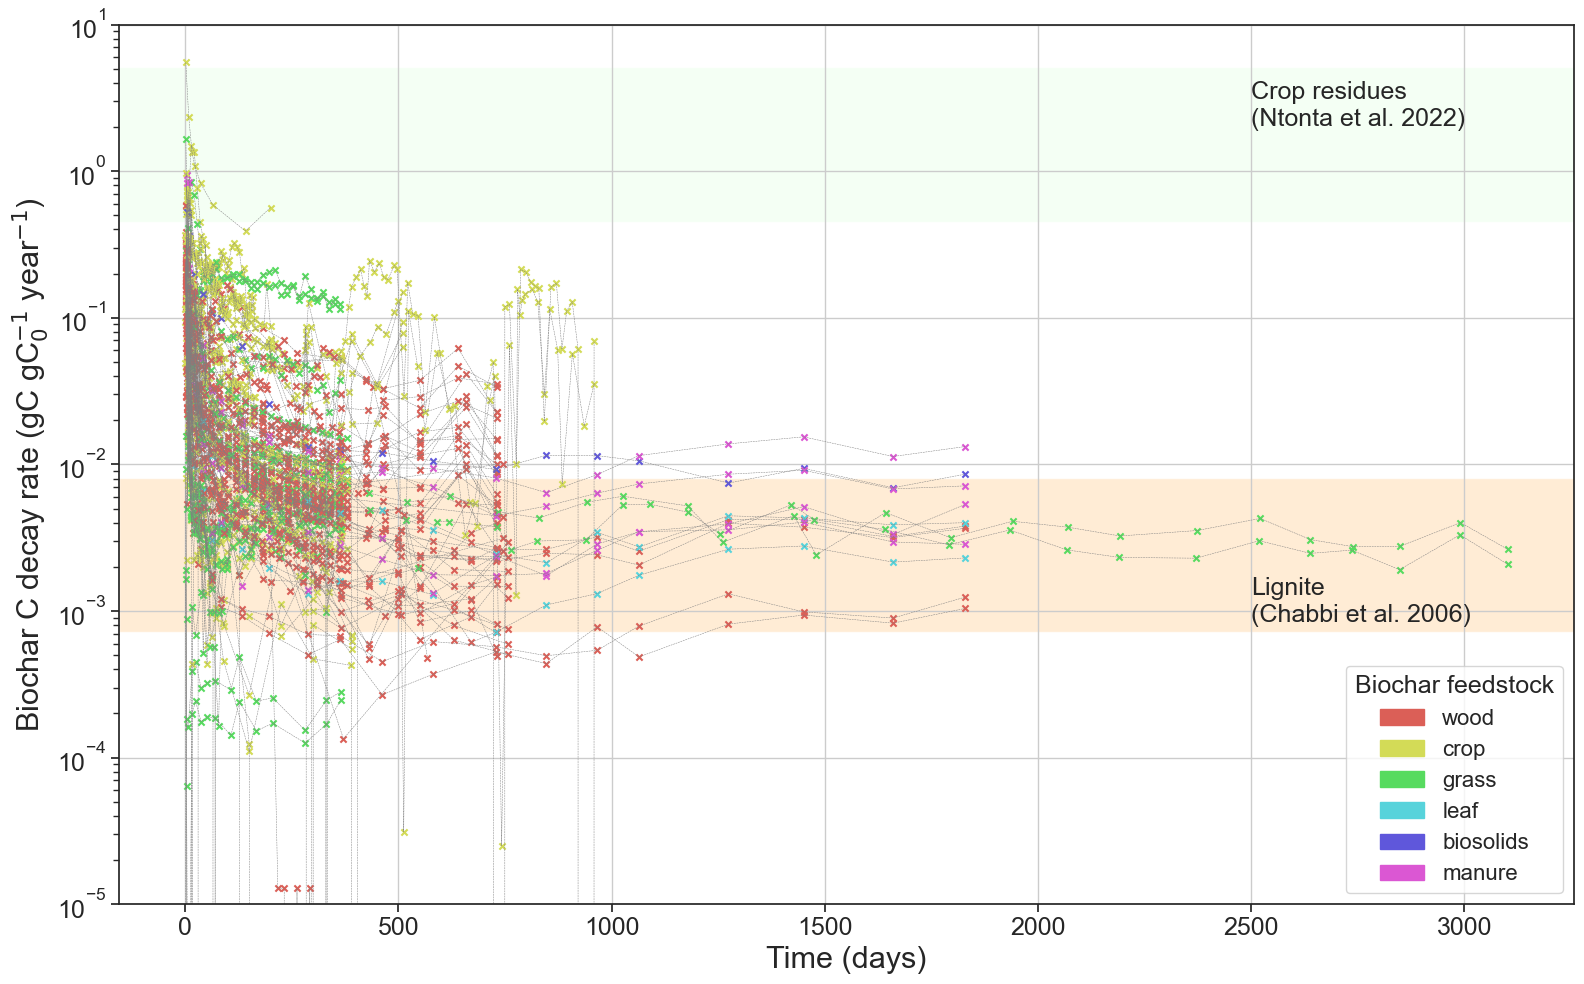

In [5]:
# plot raw decay rates, in 1 subplot, log scale y and x
# yearly
# without raw-biomass in dataset
yearly = 365
months_cutoffs, sets_incubations, sets_labels = bs.classify_observations_by_duration(metadata, months_cutoffs=[0])

fig, axes, axl = bs.plot_timeseries_by_group(data, metadata, sets_incubations, 'k_bc_reld', titles=[''],
                                             ylabel=r"Biochar C decay rate (gC/gC$_{0}$/year)", factor=yearly,
                                             line=True, lw=0.35,
                                             exclude_obs=[49, 56, 169, 170],
                                             color_list='BiomassClass', legend_title='Biochar feedstock',
                                             nrows=1, ncols=1, saveFig=False)

[axl[i].set_yscale('log') for i in range(len(axl))] # y-log scale
#[axl[i].set_xscale('log') for i in range(len(axl))] # x-log scale

[axl[i].set_xlabel(xlabel="Time (days)", fontsize=22) for i in range(len(axl))] # label and size
[axl[i].set_ylabel(ylabel=r"Biochar C decay rate (gC gC$_{0}^{-1}$ year$^{-1}$)", fontsize=22) for i in range(len(axl))] # label and size
#[axl[i].get_legend().remove() for i in range(len(axl))]

# add range decay rates of raw crop residue, from Ntonta2022
low_value = 1.24e-3*yearly # 4e-3*yearly # gCO2-C per gC added per year
high_value = 1.4e-2*yearly # 1.1e-2*yearly # gCO2-C per gC added per year
annotation_text = 'Crop residues\n(Ntonta et al. 2022)'
axl[0].axhspan(low_value, high_value, facecolor='honeydew', alpha=0.7, zorder=-100)

# Add text annotation within the shaded area
x_pos = 2500
y_pos = (low_value + high_value) / 2
plt.text(x_pos, y_pos, annotation_text, ha='left', va='center', fontsize=18)

# add range decay rates of lignite, in diff redox conditions, after 450 days, from Chabbi2006
low_value = 1.97e-6*yearly # gCO2-C per gC added per year
high_value = 2.2e-5*yearly # gCO2-C per gC added per year
annotation_text = 'Lignite\n(Chabbi et al. 2006)'
axl[0].axhspan(low_value, high_value, facecolor='bisque', alpha=0.7, zorder=-100)
# Add text annotation within the shaded area
y_pos = low_value *1.6
plt.text(x_pos, y_pos, annotation_text, ha='left', va='center', fontsize=18)

# tickparams
axl[0].tick_params(labelsize=18)
axl[0].grid(axis='both')

axl[0].set_ylim([1e-5, 1e1]) # ylim in log-scale
fig.tight_layout()
plt.savefig("../simulations/manuscript/Figure3_timeseries_yearly_decay_rates_logscale_annotated.png", dpi=900)
plt.show()


> Ntonta, S., I. Mathew, R. Zengeni, P. Muchaonyerwa, and V. Chaplot, 2022, Crop residues differ in their decomposition dynamics: Review of available data from world literature: Geoderma, v. 419, https://doi.org/10.1016/j.geoderma.2022.115855

* Extracted range of decay rates, average over 0-120 days, from table 6, for range of crop types, selecting mean +/- std, decay relative to control (priming not captured)

> Chabbi, A., Rumpel, C., Grootes, P.M., González-Pérez, J.A., Delaune, R.D., Gonzalez-Vila, F., Nixdorf, B., Hüttl, R.F., 2006. Lignite degradation and mineralization in lignite-containing mine sediment as revealed by 14C activity measurements and molecular analysis. Org. Geochem. 37, 957–976. https://doi.org/https://doi.org/10.1016/j.orggeochem.2006.02.002

* Extracted range of decay rates, after 450 days, for lignite in different redox conditions, with isotopic fractions

* Could find other data, for coal/anthracite decay rates?


### Fig. Comparing C lost: biomass & corresponding chars

In [51]:
# manual selections of observations
biomass_chars = {175:[176, 177], #Zhu2019, 400C, 700C
                 169:[171, 173], #Santos2021, topsoil, 300C, 450C
                 170:[172, 174], #Santos2021, subsoil, 300C, 450C
                # 112:[113, 114, 115, 116], #Liu2020, 200C, 300/500 with 2.5h and 10h RT
                 49: [50, 51, 52, 53, 54, 55], #Budai2016, Cornbob
                 56: [57, 58, 59, 60, 61, 62, 63, 64, 65], #Budai2016, Miscanthus
                }

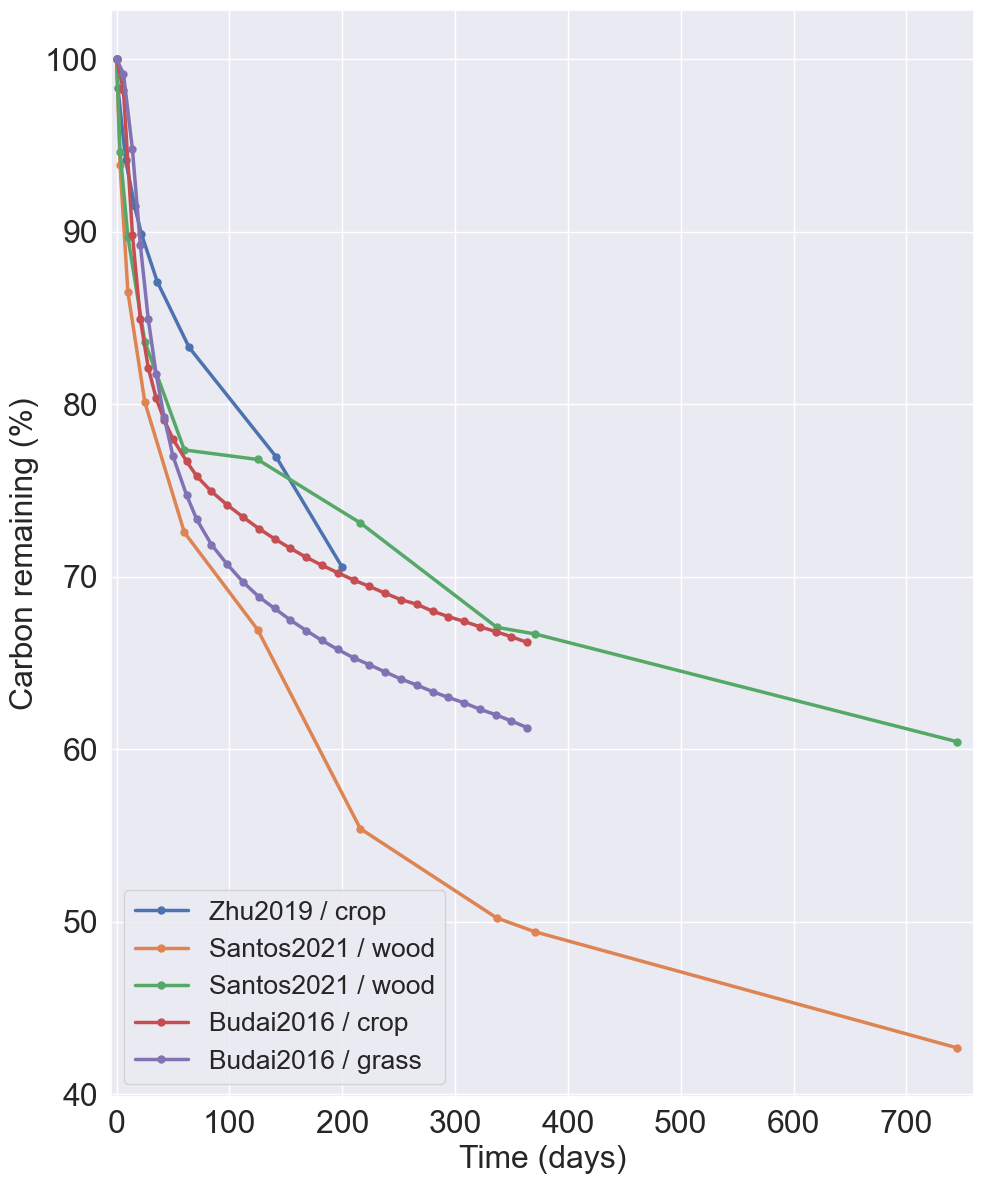

In [178]:
ts = 23
# get the timeseries
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
texts=[]
for b, chars in biomass_chars.items():   
    # raw biomass, plot
    name = metadata.loc[b, 'AuthorDate'] + ' / ' + metadata.loc[b, 'BiomassClass']
    x, y = bs.select_timeseries(b, data, 'C_bc_rem_rel', factor=100)
    ax.plot(x,y, '-o', ms=5, lw=2.5, label=name)
    last_color = plt.gca().lines[-1].get_color() 
    
    # plot corresponding biochars
    
adjust_text(texts)
ax.legend(loc='lower left', fontsize=19)
ax.set_xlim([-5, 760])
ax.set_xlabel('Time (days)', size=ts)
plt.yticks(fontsize=ts)
plt.xticks(fontsize=ts)
ax.set_ylabel('Carbon remaining (%)', size=ts);
fig.tight_layout()
plt.savefig('simulations/manuscript/carbonloss-biomass-biochars_1.png', dpi=600)

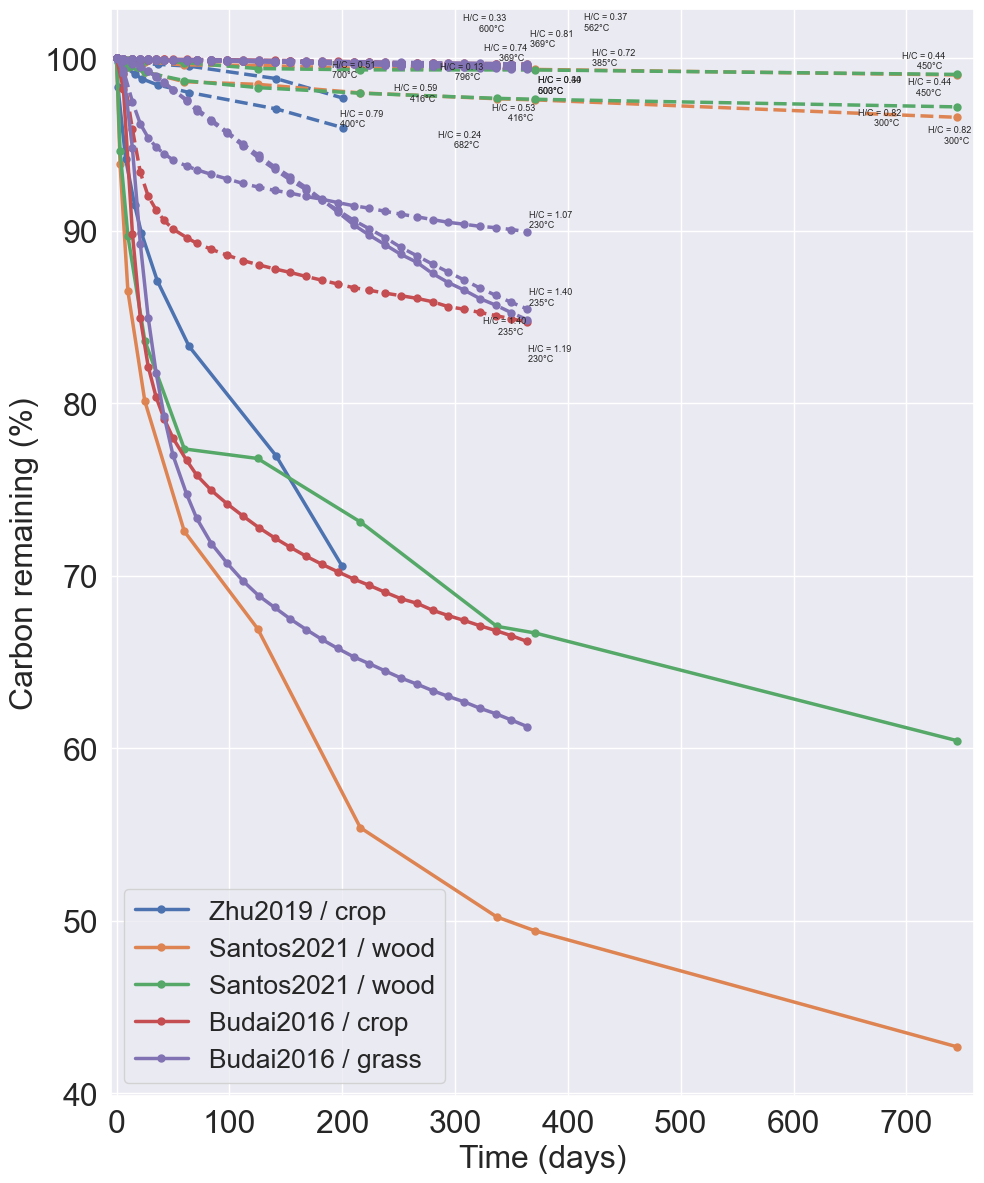

In [179]:
# get the timeseries
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
texts=[]
for b, chars in biomass_chars.items():   
    # raw biomass, plot
    name = metadata.loc[b, 'AuthorDate'] + ' / ' + metadata.loc[b, 'BiomassClass']
    x, y = bs.select_timeseries(b, data, 'C_bc_rem_rel', factor=100)
    ax.plot(x,y, '-o', ms=5, lw=2.5, label=name)
    last_color = plt.gca().lines[-1].get_color() 
    
    # plot corresponding biochars
    for c in chars:
        x, y = bs.select_timeseries(c, data, 'C_bc_rem_rel', factor=100)
        ax.plot(x,y, '--o', ms=5, lw=2.5, color=last_color)
        # annotate with H/C and HTT
        txt = 'H/C = {:0.2f}\n{:0.0f}°C '.format(metadata.loc[c, 'H/C_tot'], metadata.loc[c, 'HHT'])
        texts.append(ax.annotate(txt, (x[-1], y[-1]), xycoords='data', size=6.5))

adjust_text(texts)
ax.legend(loc='lower left', fontsize=19)
ax.set_xlim([-5, 760])
ax.set_xlabel('Time (days)', size=ts)
plt.yticks(fontsize=ts)
plt.xticks(fontsize=ts)
ax.set_ylabel('Carbon remaining (%)', size=ts);
fig.tight_layout()

fig.tight_layout()
plt.savefig('simulations/manuscript/carbonloss-biomass-biochars_2.png', dpi=600)

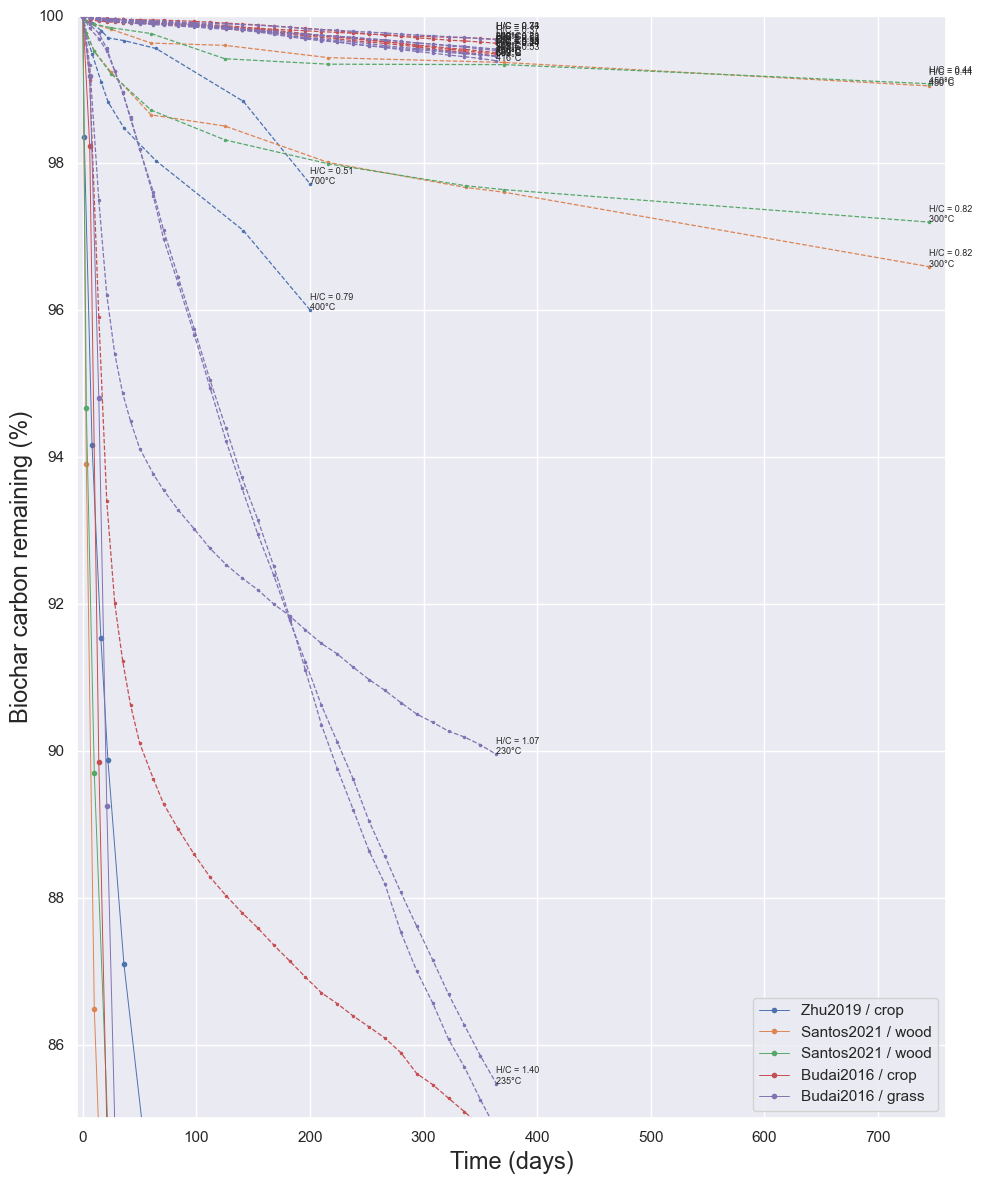

In [97]:
# get the timeseries
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
texts=[]
for b, chars in biomass_chars.items():   
    # raw biomass, plot
    name = metadata.loc[b, 'AuthorDate'] + ' / ' + metadata.loc[b, 'BiomassClass']
    x, y = bs.select_timeseries(b, data, 'C_bc_rem_rel', factor=100)
    ax.plot(x,y, '-o', ms=3, lw=0.7, label=name)
    last_color = plt.gca().lines[-1].get_color() 
    
    # plot corresponding biochars
    for c in chars:
        x, y = bs.select_timeseries(c, data, 'C_bc_rem_rel', factor=100)
        ax.plot(x,y, '--o', ms=1.5, lw=0.9, color=last_color)
        # annotate with H/C and HTT
        txt = 'H/C = {:0.2f}\n{:0.0f}°C '.format(metadata.loc[c, 'H/C_tot'], metadata.loc[c, 'HHT'])
        texts.append(ax.annotate(txt, (x[-1], y[-1]), xycoords='data', size=6.5))

#adjust_text(texts)
ax.legend()
ax.set_xlim([-5, 760])
ax.set_ylim([85, 100])

ax.set_xlabel('Time (days)', size=17)
ax.set_ylabel('Biochar carbon remaining (%)', size=17);

fig.tight_layout()
plt.savefig('simulations/manuscript/carbonloss-biomass-biochars_3.png', dpi=600)

### Fig. Decay rates histograms over time

In [227]:
inter = 6*30.5 # 6 months

def bin_the_data_obs(obs, data, inter=30.5*6, maxdur=None):
    '''
    For selected observations, bins the data over period maxdur (in days) and interval inter (in days).
    - decay rates are averaged over the time window
    - cumulative lost carbon at end of time window is selected
    Returns a dataframe with the binned data.
    '''
    x,yloss = bs.select_timeseries(obs, data, col_to_plot='C_bc_loss_rel', factor=1)
    _,yrate = bs.select_timeseries(obs, data, col_to_plot='k_bc_reld', factor=1)
    df = pd.DataFrame({'x':x, 'yloss':yloss, 'yrate':yrate})

    if maxdur == None:
        maxdur = df.x.iloc[-1] #x[-1] # max(x) , equivalent since x is ordered
        nwindows = int(np.floor(maxdur/inter))+2 # implies that will end with a nan when maxdur is equal to length
    nwindows = int(np.floor(maxdur/inter))
    wdf = pd.DataFrame(0, index=np.arange(nwindows), columns=['day_range', 'yloss', 'yrate'])

    for i in range(nwindows):
        selection = df[(df.x >= inter*i) & (df.x < inter*(i+1))]
        wdf.iat[i,wdf.columns.get_loc('day_range')] = str(int(inter*i))+' - '+str(int(inter*(i+1)))
        if selection.size == 0:
            wdf.iat[i,wdf.columns.get_loc('yloss')] = np.nan
            wdf.iat[i,wdf.columns.get_loc('yrate')] = np.nan
        else:
            wdf.iat[i,wdf.columns.get_loc('yloss')] = selection.yloss.iloc[-1] # cumulative lost at end of time window
            wdf.iat[i,wdf.columns.get_loc('yrate')] = np.average(selection.yrate) # average decay rate over time window
    
    return wdf

def bin_all_data(data, inter=30.5*6, maxdur=30.5*12, start=1, factor=1, exclude_obs=[]):
    '''
    For selected observations, bins the data over period maxdur (in days) and interval inter (in days).
    - decay rates are averaged over the time window
    - cumulative lost carbon at end of time window is selected
    
    
    Returns 2 dataframes with the binned data, for C_bc_loss_rel and k_bc_reld.
    
    WARNING: np.mean returns nan if one value is nan > replace by pd.mean
    start= shall set to 1 or more, to exclude value at t=0 which is 0.0 by construction (and loss is 0.0)
    
    '''
    nwindows = int(np.floor(maxdur/inter))
    obs = data['ID_obs'].unique()
    
    wdf_rate = pd.DataFrame(0, index=np.arange(nwindows), columns=['day_range'])
    wdf_loss = pd.DataFrame(0, index=np.arange(nwindows), columns=['day_range'])    
    dict_rates={}
    dict_losses={}
    z = 0
    for o in obs:
        if o in exclude_obs:
            continue
        try:
            x,yloss = bs.select_timeseries(o, data, col_to_plot='C_bc_loss_rel', factor=factor)
        except Exception:
            #print("C_bc_loss_rel missing for: ", o)
            continue
        try:
            _,yrate = bs.select_timeseries(o, data, col_to_plot='k_bc_rel0', factor=factor)
        except Exception:
            #print("k_bc_reld missing for: ", o)
            continue
            
        df = pd.DataFrame({'x':x, 'yloss':yloss, 'yrate':yrate})
        rates = []
        losses = []
        for i in range(nwindows):
            selection = df[(df.x >= start+inter*i) & (df.x < start+inter*(i+1))]
               
                
            if z == 0: # do this only once
                wdf_rate.iat[i,wdf_rate.columns.get_loc('day_range')] = str(int(start+inter*i))+' - '+str(int(start+inter*(i+1)))
                wdf_loss.iat[i,wdf_loss.columns.get_loc('day_range')] = str(int(start+inter*i))+' - '+str(int(start+inter*(i+1)))
            
            if selection.size == 0:
                rates.append(np.nan)
                losses.append(np.nan)
            else:
                rates.append(selection.yrate.mean(skipna=True))
                losses.append(selection.yloss.iloc[-1])
        dict_rates[str(o)] = rates
        dict_losses[str(o)] = losses
        z=1
    wdf_rate = pd.concat([wdf_rate, pd.DataFrame(dict_rates)], axis=1)
    wdf_loss = pd.concat([wdf_loss, pd.DataFrame(dict_losses)], axis=1) 
    
    return wdf_rate, wdf_loss

In [13]:
# plot 1
wdf_rate1, wdf_loss1 = bin_all_data(data, inter=9, maxdur=30, start=1)
wdf_rate1.set_index('day_range', inplace=True)
wdf_rate1.isnull().sum(axis=1)/112*100

# plot 2
wdf_rate2, wdf_loss2 = bin_all_data(data, inter=20, maxdur=60, start=1+28)
wdf_rate2.set_index('day_range', inplace=True)
wdf_rate2.isnull().sum(axis=1)/112*100

# plot 3
wdf_rate3, wdf_loss3 = bin_all_data(data, inter=35, maxdur=30*9+10, start=1+89)
wdf_rate3.set_index('day_range', inplace=True)
wdf_rate3.isnull().sum(axis=1)/112*100

# plot 4
wdf_rate4, wdf_loss4 = bin_all_data(data, inter=30*4, maxdur=365*8-4*30, start=1+370)
wdf_rate4.set_index('day_range', inplace=True)
#wdf_rate4.isnull().sum(axis=1)/112*100


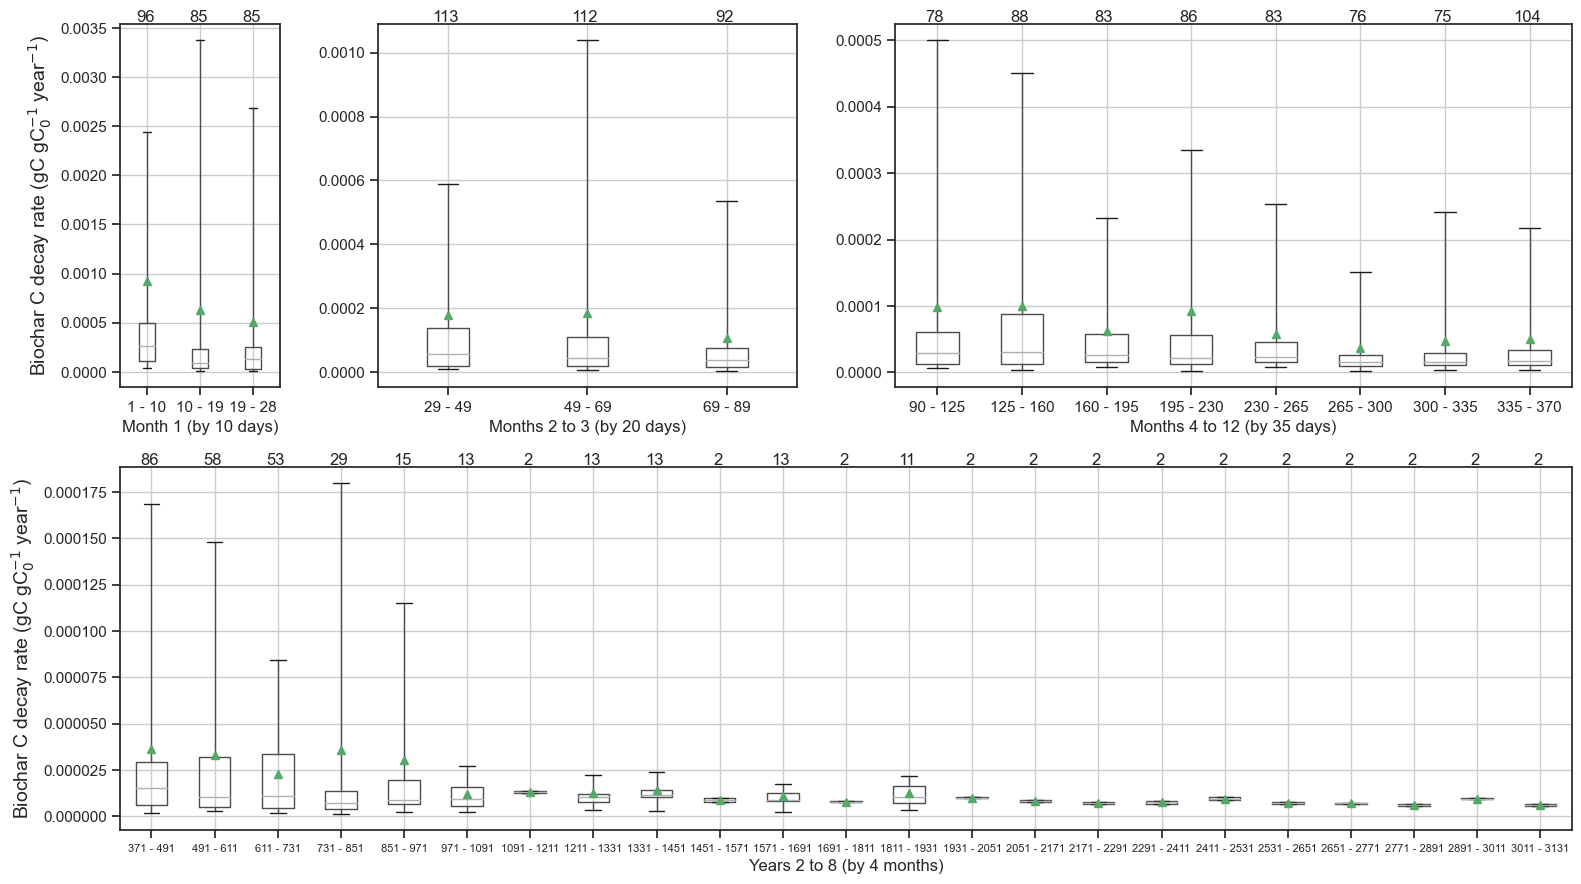

In [8]:
fig = plt.figure(figsize=(16,9))
# sizes
r = 2
c = 6
ax1 = plt.subplot(r,c,(1, 1)) # month 1
ax2 = plt.subplot(r,c,(2, 3)) # months 2-3
ax3 = plt.subplot(r,c,(4, 6)) # months 4-12
ax4 = plt.subplot(r,c,(7, 12))# year 2 to 8

# data plot
wdf_rate1.T.boxplot(ax=ax1, showfliers=False, showmeans=True, whis=[5, 95])
wdf_rate2.T.boxplot(ax=ax2, showfliers=False, showmeans=True, whis=[5, 95])
wdf_rate3.T.boxplot(ax=ax3, showfliers=False, showmeans=True, whis=[5, 95])
wdf_rate4.T.boxplot(ax=ax4, showfliers=False, showmeans=True, whis=[5, 95])

# y label & ticks
yt = r"Biochar C decay rate (gC gC$_{0}^{-1}$ year$^{-1}$)"
ax1.set_ylabel(yt, fontsize=14)
ax2.set_ylabel(' ')
ax3.set_ylabel(' ')
ax4.set_ylabel(yt, fontsize=14)
#plt.ticklabel_format(axis='both', style='sci', scilimits=(4,4))

n1 = wdf_rate1.notnull().sum(axis=1)
n2 = wdf_rate2.notnull().sum(axis=1)
n3 = wdf_rate3.notnull().sum(axis=1)
n4 = wdf_rate4.notnull().sum(axis=1)
n=n1
for tick, label in enumerate(n):
    ax1.annotate(label, (tick/len(n)+0.16, 1.005), fontsize=12, xycoords='axes fraction', ha='center')
n=n2
for tick, label in enumerate(n):
    ax2.annotate(label, (tick/len(n)+0.16, 1.005), fontsize=12, xycoords='axes fraction', ha='center')
n=n3
for tick, label in enumerate(n):
    ax3.annotate(label, (tick/len(n)+0.47/len(n), 1.005), fontsize=12, xycoords='axes fraction', ha='center')
n=n4
for tick, label in enumerate(n):
    ax4.annotate(label, (tick/len(n)+0.47/len(n), 1.005), fontsize=12, xycoords='axes fraction', ha='center')

# x label
ax1.set_xlabel("Month 1 (by 10 days)")
ax2.set_xlabel("Months 2 to 3 (by 20 days)")
ax3.set_xlabel("Months 4 to 12 (by 35 days)")
ax4.set_xlabel("Years 2 to 8 (by 4 months)")
ax4.tick_params(axis='x', which='major', labelsize=8)

fig.tight_layout()
plt.savefig("simulations/timeseries_decay_binned.png", dpi=300)
plt.show()

In [14]:
# plot 1
wdf_rate1, wdf_loss1 = bin_all_data(data, inter=9, maxdur=30, start=1, factor=365, exclude_obs=[49, 56, 169, 170])
wdf_rate1.set_index('day_range', inplace=True)
wdf_rate1.isnull().sum(axis=1)/112*100

# plot 2
wdf_rate2, wdf_loss2 = bin_all_data(data, inter=20, maxdur=60, start=1+28, factor=365, exclude_obs=[49, 56, 169, 170])
wdf_rate2.set_index('day_range', inplace=True)
wdf_rate2.isnull().sum(axis=1)/112*100

# plot 3
wdf_rate3, wdf_loss3 = bin_all_data(data, inter=35, maxdur=30*9+10, start=1+89, factor=365, exclude_obs=[49, 56, 169, 170])
wdf_rate3.set_index('day_range', inplace=True)
wdf_rate3.isnull().sum(axis=1)/112*100

# plot 4
wdf_rate4, wdf_loss4 = bin_all_data(data, inter=30*4, maxdur=365*8-4*30, start=1+370, factor=365, exclude_obs=[49, 56, 169, 170])
wdf_rate4.set_index('day_range', inplace=True)
#wdf_rate4.isnull().sum(axis=1)/112*100


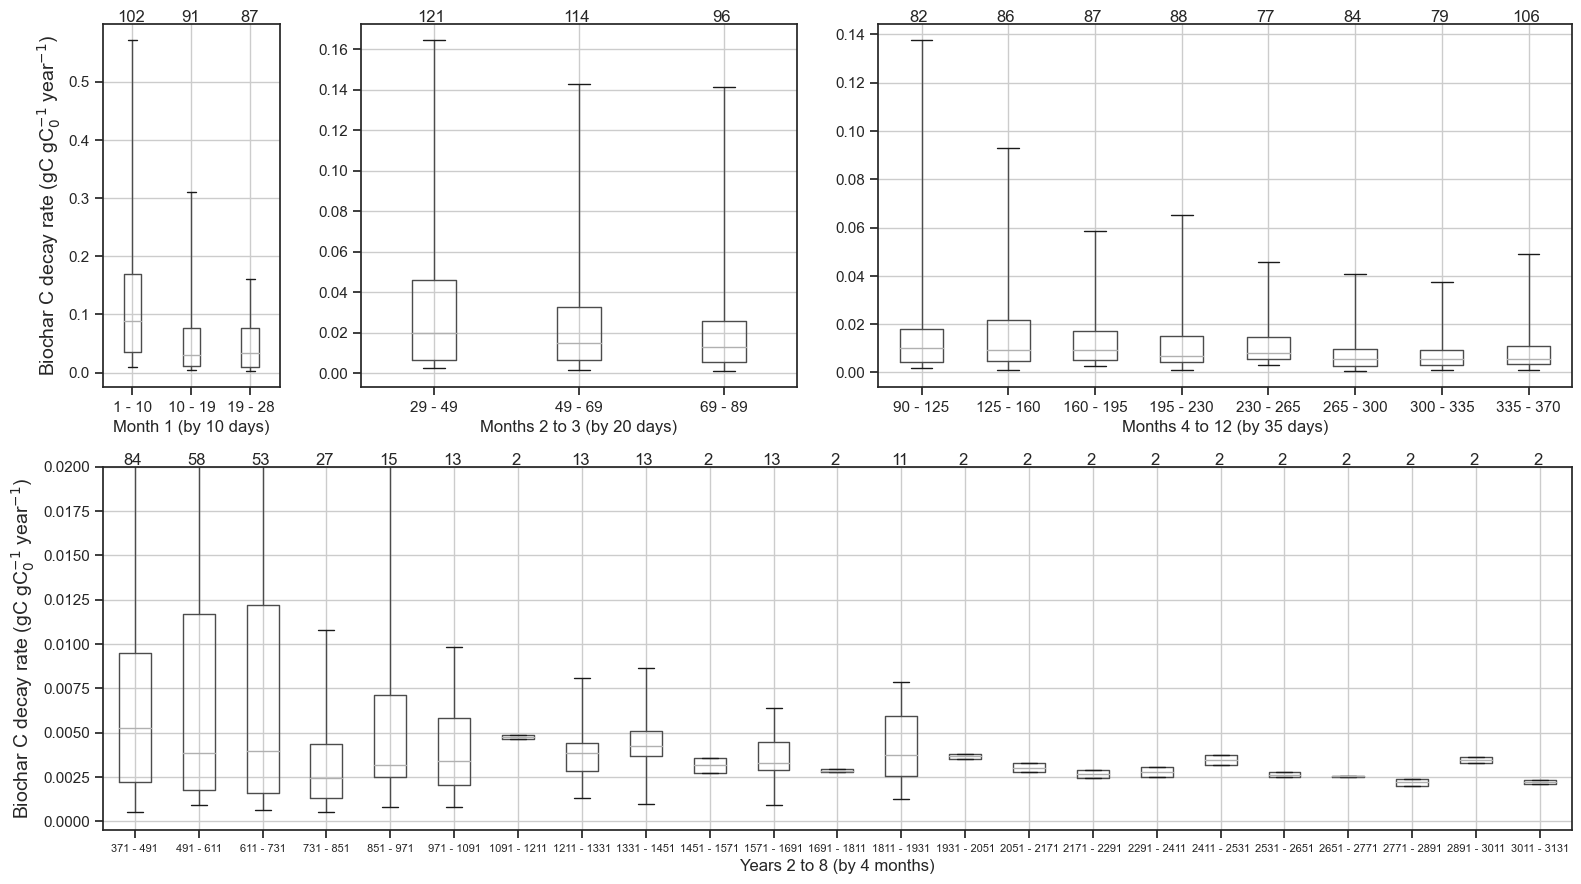

In [15]:
fig = plt.figure(figsize=(16,9))
# sizes
r = 2
c = 6
ax1 = plt.subplot(r,c,(1, 1)) # month 1
ax2 = plt.subplot(r,c,(2, 3)) # months 2-3
ax3 = plt.subplot(r,c,(4, 6)) # months 4-12
ax4 = plt.subplot(r,c,(7, 12))# year 2 to 8

# data plot
withWhisker=  [5, 95] # False #
wdf_rate1.T.boxplot(ax=ax1, showfliers=False, showmeans=False, whis=withWhisker)#[5, 95])
wdf_rate2.T.boxplot(ax=ax2, showfliers=False, showmeans=False, whis=withWhisker)#[5, 95])
wdf_rate3.T.boxplot(ax=ax3, showfliers=False, showmeans=False, whis=withWhisker)#[5, 95])
wdf_rate4.T.boxplot(ax=ax4, showfliers=False, showmeans=False, whis=withWhisker)#[5, 95])

# y label & ticks
yt = r"Biochar C decay rate (gC gC$_{0}^{-1}$ year$^{-1}$)"
ax1.set_ylabel(yt, fontsize=14)
ax2.set_ylabel(' ')
ax3.set_ylabel(' ')
ax4.set_ylabel(yt, fontsize=14)
#plt.ticklabel_format(axis='both', style='sci', scilimits=(4,4))

n1 = wdf_rate1.notnull().sum(axis=1)
n2 = wdf_rate2.notnull().sum(axis=1)
n3 = wdf_rate3.notnull().sum(axis=1)
n4 = wdf_rate4.notnull().sum(axis=1)
n=n1
for tick, label in enumerate(n):
    ax1.annotate(label, (tick/len(n)+0.16, 1.005), fontsize=12, xycoords='axes fraction', ha='center')
n=n2
for tick, label in enumerate(n):
    ax2.annotate(label, (tick/len(n)+0.16, 1.005), fontsize=12, xycoords='axes fraction', ha='center')
n=n3
for tick, label in enumerate(n):
    ax3.annotate(label, (tick/len(n)+0.47/len(n), 1.005), fontsize=12, xycoords='axes fraction', ha='center')
n=n4
for tick, label in enumerate(n):
    ax4.annotate(label, (tick/len(n)+0.47/len(n), 1.005), fontsize=12, xycoords='axes fraction', ha='center')

# x label
ax1.set_xlabel("Month 1 (by 10 days)")
ax2.set_xlabel("Months 2 to 3 (by 20 days)")
ax3.set_xlabel("Months 4 to 12 (by 35 days)")
ax4.set_xlabel("Years 2 to 8 (by 4 months)")
ax4.set_ylim([-0.0005, 0.02])

ax4.tick_params(axis='x', which='major', labelsize=8)

fig.tight_layout()
plt.savefig("../simulations/manuscript/FigureS6_timeseries_yearly_decay_rates_binned.png", dpi=300)
plt.show()

### Table. Cumulative C lost at end of exp, per groups

In [16]:
# last measured decay rate and time for each observation
cum_loss = []
last_measured_time = []
for o in metadata.index:
    try:
        time,closs = bs.select_timeseries(o, data, col_to_plot='C_bc_loss_rel', factor=100)
        cum_loss.append(closs[-1])
        last_measured_time.append(time[-1])
    except Exception:
        print("data missing for: ", o)
        cum_loss.append(np.nan)
        last_measured_time.append(np.nan)

cumLoss = metadata.copy(deep=True)
cumLoss['cumLoss'] = cum_loss
cumLoss['LastMeasured'] = last_measured_time

data missing for:  39
data missing for:  104
data missing for:  105
data missing for:  106
data missing for:  107
data missing for:  108
data missing for:  109
data missing for:  110
data missing for:  111
data missing for:  130
data missing for:  131
data missing for:  132
data missing for:  133
data missing for:  134
data missing for:  135
data missing for:  136
data missing for:  137
data missing for:  138
data missing for:  139
data missing for:  140
data missing for:  141
data missing for:  142
data missing for:  143
data missing for:  144
data missing for:  145
data missing for:  146
data missing for:  147
data missing for:  148
data missing for:  149
data missing for:  150
data missing for:  151
data missing for:  152
data missing for:  153
data missing for:  154
data missing for:  155
data missing for:  156
data missing for:  157
data missing for:  158
data missing for:  159
data missing for:  160
data missing for:  161
data missing for:  162
data missing for:  163
data missing

In [17]:
# fresh biomass exclusion
ooo = cumLoss[ cumLoss['PyrolysisClass'] == 'no-treat']['cumLoss']
print(  '{:0.1f}, {:0.1f}, {:0.1f} ({:0.0f}) '.format(ooo.min(), ooo.median(), ooo.max(), len(ooo))   )

29.4, 38.7, 57.3 (5) 


In [24]:
# all biochars, all times
th = 2.*365
ooo = cumLoss[ cumLoss['PyrolysisClass'] != 'no-treat'
             ][['cumLoss', 'IncubationDuration']]
ooo = ooo.dropna()
ooo_short = ooo[ooo['IncubationDuration'] < th]['cumLoss']
ooo_long = ooo[ooo['IncubationDuration'] >= th]['cumLoss']

print('short', '{:0.2f}, {:0.1f}, {:0.1f} ({:0.0f}) '.format(ooo_short.min(), ooo_short.median(), ooo_short.max(), len(ooo_short))   )
print('long','{:0.1f}, {:0.1f}, {:0.1f} ({:0.0f}) '.format(ooo_long.min(), ooo_long.median(), ooo_long.max(), len(ooo_long))   )
print(  '{:0.3f}, {:0.1f}, {:0.1f} ({:0.0f}) '.format(ooo.cumLoss.min(), ooo.cumLoss.median(), ooo.cumLoss.max(), len(ooo.cumLoss))   )
print(len(ooo_short)+len(ooo_long), len(ooo))


short 0.02, 1.1, 15.3 (72) 
long 0.4, 1.9, 22.6 (57) 
0.017, 1.4, 22.6 (129) 
129 129


In [25]:
# all biochars, per biomass class
for c in metadata.BiomassClass.unique():
    ooo = cumLoss[ (cumLoss['PyrolysisClass'] != 'no-treat')
                  & (cumLoss['BiomassClass'] == c)
                 ][['cumLoss', 'IncubationDuration']]
    ooo = ooo.dropna()
    ooo_short = ooo[ooo['IncubationDuration'] < th]['cumLoss']
    ooo_long = ooo[ooo['IncubationDuration'] >= th]['cumLoss']
    
    print(c,'short', '{:0.1f}, {:0.1f}, {:0.1f} ({:0.0f}) '.format(ooo_short.min(), ooo_short.median(), ooo_short.max(), len(ooo_short))   )
    print(c, 'long','{:0.1f}, {:0.1f}, {:0.1f} ({:0.0f}) '.format(ooo_long.min(), ooo_long.median(), ooo_long.max(), len(ooo_long))   )

wood short 0.5, 1.2, 7.0 (23) 
wood long 0.4, 1.5, 10.9 (46) 
crop short 0.2, 1.2, 15.3 (30) 
crop long 14.9, 18.7, 22.6 (2) 
grass short 0.0, 0.6, 15.2 (19) 
grass long 5.5, 5.6, 5.8 (2) 
leaf short nan, nan, nan (0) 
leaf long 1.2, 1.9, 2.5 (2) 
biosolids short nan, nan, nan (0) 
biosolids long 8.9, 8.9, 8.9 (1) 
manure short nan, nan, nan (0) 
manure long 2.1, 4.6, 7.3 (4) 
nan short nan, nan, nan (0) 
nan long nan, nan, nan (0) 


In [21]:
# all biochars, per pyrolysis class
th = 2.*365
for c in metadata.PyrolysisClass.unique():
    ooo = cumLoss[ (cumLoss['PyrolysisClass'] == c)
                 ][['cumLoss', 'IncubationDuration']]
    ooo = ooo.dropna()
    ooo_short = ooo[ooo['IncubationDuration'] < th]['cumLoss']
    ooo_long = ooo[ooo['IncubationDuration'] >= th]['cumLoss']
    
    print(c,'short', '{:0.1f}, {:0.1f}, {:0.1f} ({:0.0f}) '.format(ooo_short.min(), ooo_short.median(), ooo_short.max(), len(ooo_short))   )
    print(c, 'long','{:0.1f}, {:0.1f}, {:0.1f} ({:0.0f}) '.format(ooo_long.min(), ooo_long.median(), ooo_long.max(), len(ooo_long))   )

pyr-slow short 0.0, 1.1, 15.2 (67) 
pyr-slow long 0.4, 1.8, 10.9 (55) 
gas short 2.8, 5.3, 7.7 (2) 
gas long 14.9, 18.7, 22.6 (2) 
no-treat short 29.4, 33.8, 38.7 (3) 
no-treat long 39.6, 48.4, 57.3 (2) 
htc short 10.0, 12.7, 15.3 (2) 
htc long nan, nan, nan (0) 
pyr-flash short 0.5, 0.5, 0.5 (1) 
pyr-flash long nan, nan, nan (0) 
nan short nan, nan, nan (0) 
nan long nan, nan, nan (0) 


In [26]:
# all biochars, per H/C class
th = 2.*365
cumLoss = cumLoss.replace('na',np.NaN)
cumLoss['H/C_all'] = cumLoss['H/C_org'].fillna(cumLoss['H/C_tot'], inplace=False)

c1=-1
c2=0.3
ooo = cumLoss[ (cumLoss['H/C_all'] >= c1)
              & (cumLoss['H/C_all'] < c2)
              & (cumLoss['PyrolysisClass'] != 'no-treat')
             ][['cumLoss', 'IncubationDuration']]
ooo = ooo.dropna()
ooo_short = ooo[ooo['IncubationDuration'] < th]['cumLoss']
ooo_long = ooo[ooo['IncubationDuration'] >= th]['cumLoss']
    
print(c1, c2, 'short', '{:0.1f}, {:0.1f}, {:0.1f} ({:0.0f}) '.format(ooo_short.min(), ooo_short.median(), ooo_short.max(), len(ooo_short))   )
print(c1, c2, 'long','{:0.1f}, {:0.1f}, {:0.1f} ({:0.0f}) '.format(ooo_long.min(), ooo_long.median(), ooo_long.max(), len(ooo_long))   )

c1=c2
c2=0.7
ooo = cumLoss[ (cumLoss['H/C_all'] >= c1)
              & (cumLoss['H/C_all'] < c2)
              & (cumLoss['PyrolysisClass'] != 'no-treat')
             ][['cumLoss', 'IncubationDuration']]
ooo = ooo.dropna()
ooo_short = ooo[ooo['IncubationDuration'] < th]['cumLoss']
ooo_long = ooo[ooo['IncubationDuration'] >= th]['cumLoss']
    
print(c1, c2, 'short', '{:0.1f}, {:0.1f}, {:0.1f} ({:0.0f}) '.format(ooo_short.min(), ooo_short.median(), ooo_short.max(), len(ooo_short))   )
print(c1, c2, 'long','{:0.1f}, {:0.1f}, {:0.1f} ({:0.0f}) '.format(ooo_long.min(), ooo_long.median(), ooo_long.max(), len(ooo_long))   )

c1=c2
c2=1.0
ooo = cumLoss[ (cumLoss['H/C_all'] >= c1)
              & (cumLoss['H/C_all'] < c2)
              & (cumLoss['PyrolysisClass'] != 'no-treat')
             ][['cumLoss', 'IncubationDuration']]
ooo = ooo.dropna()
ooo_short = ooo[ooo['IncubationDuration'] < th]['cumLoss']
ooo_long = ooo[ooo['IncubationDuration'] >= th]['cumLoss']
    
print(c1, c2, 'short', '{:0.1f}, {:0.1f}, {:0.1f} ({:0.0f}) '.format(ooo_short.min(), ooo_short.median(), ooo_short.max(), len(ooo_short))   )
print(c1, c2, 'long','{:0.1f}, {:0.1f}, {:0.1f} ({:0.0f}) '.format(ooo_long.min(), ooo_long.median(), ooo_long.max(), len(ooo_long))   )

c1=c2
c2=5
ooo = cumLoss[ (cumLoss['H/C_all'] >= c1)
              & (cumLoss['H/C_all'] < c2)
              & (cumLoss['PyrolysisClass'] != 'no-treat')
             ][['cumLoss', 'IncubationDuration']]
ooo = ooo.dropna()
ooo_short = ooo[ooo['IncubationDuration'] < th]['cumLoss']
ooo_long = ooo[ooo['IncubationDuration'] >= th]['cumLoss']
    
print(c1, c2, 'short', '{:0.1f}, {:0.1f}, {:0.1f} ({:0.0f}) '.format(ooo_short.min(), ooo_short.median(), ooo_short.max(), len(ooo_short))   )
print(c1, c2, 'long','{:0.1f}, {:0.1f}, {:0.1f} ({:0.0f}) '.format(ooo_long.min(), ooo_long.median(), ooo_long.max(), len(ooo_long))   )

-1 0.3 short 0.0, 0.4, 2.2 (9) 
-1 0.3 long nan, nan, nan (0) 
0.3 0.7 short 0.2, 1.0, 10.1 (43) 
0.3 0.7 long 0.4, 1.6, 22.6 (50) 
0.7 1.0 short 0.3, 1.3, 4.0 (15) 
0.7 1.0 long 2.2, 3.1, 6.9 (4) 
1.0 5 short 6.6, 14.5, 15.3 (5) 
1.0 5 long 7.3, 7.3, 7.3 (1) 


### Compare measured decay rates to decay rate from curve fitting in pool models

In [44]:
# load our best fit
for_model =pd.read_excel('simulations/bestfitdata-p0_2022-10-27.xlsx', index_col=0)
# load woolf data
woolf_fp= 'biocharStability/database/former-assessment/2021_Woolf_EST_Supporting Information_edited_ESA.xlsx'
woolf = pd.read_excel(woolf_fp, sheet_name='Fperm', index_col=None, usecols='A:T', skiprows=7)
woolf.set_index('ID_Woolf2021', inplace=True)
# merge two datasets
woolf_ids = list(woolf.index)
subset_metadata = metadata[metadata['ID_Woolf2021'].isin(woolf_ids)]
subset_data = data[ data['ID_obs'].isin(list(subset_metadata.index))]
subset_ids = list(subset_metadata.index)
subset_fitdata = for_model[ for_model['ID_obs'].isin(subset_ids)].copy(deep=True)
subset_fitdata['ID_Woolf2021'] = [ subset_metadata.loc[ids, 'ID_Woolf2021'] for ids in subset_fitdata['ID_obs']] # the matching

cols=['Molar Hydrogen to organic carbon ratio of the biochar', 'Temperature at which decomposition experiment was conducted (°C)',
 'C1', 'C2', 'C3', 'k1', 'k2', 'k3', 'Q10', 'fT', 'k1_fperm', 'k2_fperm', 'k3_fperm', 'Fperm', 'Fperm,initial', 'DeltaFperm']
subset_fitdata_ext = subset_fitdata.merge(woolf[cols], on='ID_Woolf2021', suffixes=(None, '_W'), validate='1:1') # the dataframe with both data

print("Our dataset & Woolf dataset have {} observations in common, for metadata.".format(len(subset_ids)))
print("Our dataset & Woolf dataset have {} observations in common, for metadata and fitdata.".format(len(subset_fitdata_ext)))


Our dataset & Woolf dataset have 71 observations in common, for metadata.
Our dataset & Woolf dataset have 66 observations in common, for metadata and fitdata.


C:\anaconda\envs\bw2\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
C:\anaconda\envs\bw2\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():


In [80]:
decayRates = subset_fitdata_ext[['ID_obs', 'model', 'k1', 'k2', 'k3', 'k1_W', 'k2_W', 'k3_W',]].copy()
# conversion to year-1, of our decay rates
decayRates['k1'] = decayRates['k1']*365
decayRates['k2'] = decayRates['k2']*365
decayRates['k3'] = decayRates['k3']*365
decayRates.replace(0, np.nan, inplace=True)

# sub-selection of the slow-pool
k_slow = []
k_slow_W = []
for i, row in decayRates.iterrows():
    k_slow.append(np.min(row[['k1', 'k2', 'k3']]) )
    k_slow_W.append(np.min(row[['k1_W', 'k2_W', 'k3_W']]))
    
decayRates['k_slow'] = k_slow
decayRates['k_slow_W'] = k_slow_W

# last measured decay rate and time for each observation
last_measured_decay = []
last_measured_time = []
for o in decayRates['ID_obs']:
    try:
        time,yrate = bs.select_timeseries(o, data, col_to_plot='k_bc_rel0', factor=365)
        last_measured_decay.append(yrate[-1])
        last_measured_time.append(time[-1]/365)
    except Exception:
        print("k_bc_reld missing for: ", o)
        last_measured_decay.append(np.nan)
        last_measured_time.append(np.nan)
decayRates['k_LM'] = last_measured_decay
decayRates['Time_LM'] = last_measured_time

decayRates

k_bc_reld missing for:  1


ID_obs        model         k1          k2          k3        k1_W  \
0        1    doubleExp   2.658834    0.002487         NaN    2.657961   
1        3    doubleExp  20.033301    0.001168         NaN   19.210526   
2        4    doubleExp   0.000361    9.827969         NaN    9.864865   
3        5    doubleExp   0.000531   19.545805         NaN   20.277778   
4        6  doubleExp_u   0.000863   20.125354         NaN   17.380952   
..     ...          ...        ...         ...         ...         ...   
61     125    tripleExp  15.692737    2.081969    0.001541  261.925747   
62     126    tripleExp   2.254890  255.742782    0.000167  149.362231   
63     127    tripleExp   0.000273    2.184685  134.197051  102.843554   
64     128    tripleExp   1.394789   94.573847    0.000122  124.108171   
65     129    tripleExp   0.001448   62.602676    2.960444  178.214888   

        k2_W  k3_W    k_slow  k_slow_W      k_LM   Time_LM  
0   0.002472   NaN  0.002487  0.002472       NaN       NaN  
1   0.001167   NaN  0.001168  0.001167  0.000688  1.069096  
2   0.000353   NaN  0.000361  0.000353  0.000552  1.068625  
3   0.000527   NaN  0.000531  0.000527  0.000424  1.067441  
4   0.001030   NaN  0.000863  0.001030  0.000673  1.068912  
..       ...   ...       ...       ...       ...       ...  
61  0.003187   NaN  0.001541  0.003187  0.002299  2.076712  
62  0.001023   NaN  0.000167  0.001023  0.000588  2.076712  
63  0.001556   NaN  0.000273  0.001556  0.000502  2.076712  
64  0.001710   NaN  0.000122  0.001710  0.000747  2.076712  
65  0.001764   NaN  0.001448  0.001764  0.002930  2.076712  

[66 rows x 12 columns]

In [81]:
decayRates[['k_slow', 'k_slow_W', 'k_LM', 'Time_LM']].T

0         1         2         3         4         5   \
k_slow    0.002487  0.001168  0.000361  0.000531  0.000863  0.001620   
k_slow_W  0.002472  0.001167  0.000353  0.000527  0.001030  0.001621   
k_LM           NaN  0.000688  0.000552  0.000424  0.000673  0.000625   
Time_LM        NaN  1.069096  1.068625  1.067441  1.068912  1.068882   

                6         7         8         9   ...        56        57  \
k_slow    0.003412  0.003715  0.010950  0.010950  ...  0.000250  0.004734   
k_slow_W  0.003380  0.002445  0.010950  0.010950  ...  0.004406  0.004096   
k_LM      0.001967  0.002482  0.082956  0.041914  ...  0.004206  0.003486   
Time_LM   8.498849  8.498877  1.397260  1.397260  ...  1.007616  1.009370   

                58        59        60        61        62        63  \
k_slow    0.000726  0.000699  0.001394  0.001541  0.000167  0.000273   
k_slow_W  0.001402  0.003102  0.003117  0.003187  0.001023  0.001556   
k_LM      0.001452  0.001836  0.001210  0.002299  0.000588  0.000502   
Time_LM   2.076712  2.076712  2.076712  2.076712  2.076712  2.076712   

                64        65  
k_slow    0.000122  0.001448  
k_slow_W  0.001710  0.001764  
k_LM      0.000747  0.002930  
Time_LM   2.076712  2.076712  

[4 rows x 66 columns]

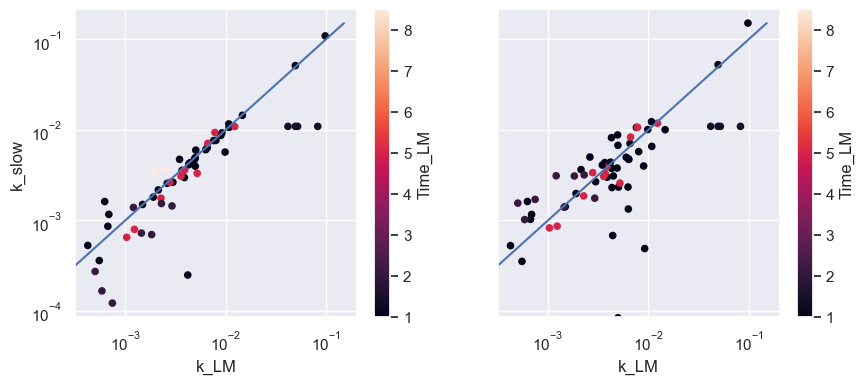

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
decayRates.plot(kind='scatter', x='k_LM', y='k_slow', ax = ax[0], legend=None, c='Time_LM')
decayRates.plot(kind='scatter', x='k_LM', y='k_slow_W', ax = ax[1], legend=None, c='Time_LM')
scale = decayRates[['k_LM', 'k_slow', 'k_slow_W']].max().max()
for i in range(2):
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].plot([0, scale], [0, scale])
    #ax[i].set_xlim([0, np.log(scale) ])
    #ax[i].set_ylim([0, np.log(scale) ])
    #ax[i].set(aspect='equal')

In [140]:
fig.savefig('simulations/comparisons_decay_rates_CF_LM.png', dpi=600)

Reflection:
- it seems to be both above and below the diagonal. 
- let's check what's the meaning of k in an exponential model, relative to the k measured in laboratory
- in an exponential decay, the "actual" decay rate over time is the one obtained by deriving the exponential somehow; in the long-run will the value tend to be equal to the k2?

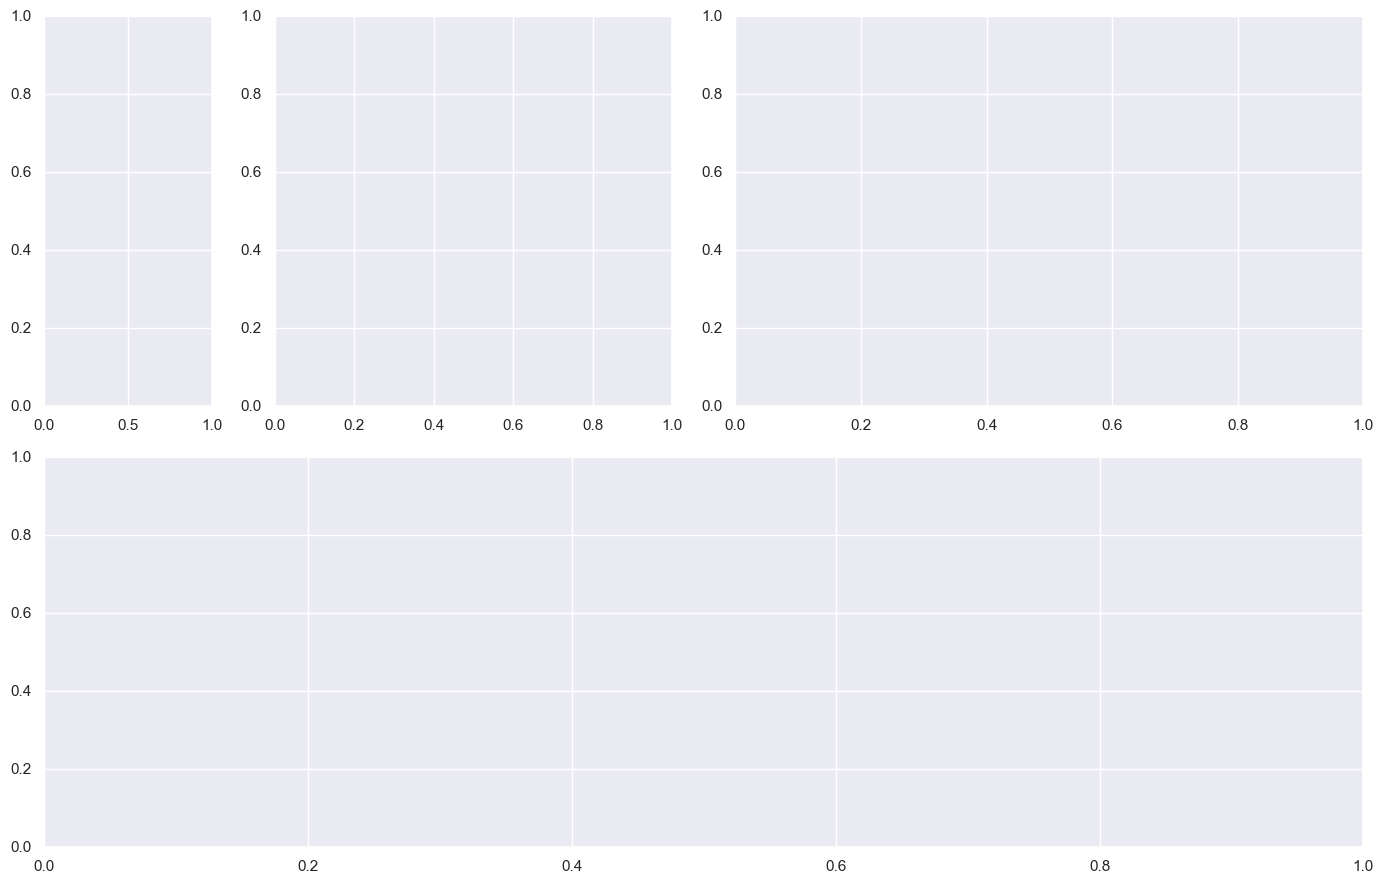

In [382]:
fig = plt.figure(figsize=(14,9))

r = 2
c = 6

ax1 = plt.subplot(r,c,(1, 1)) # month 1
ax2 = plt.subplot(r,c,(2, 3)) # months 2-3
ax3 = plt.subplot(r,c,(4, 6)) # months 4-12
ax4 = plt.subplot(r,c,(7, 12))# year 2 to 8

fig.tight_layout()
plt.show()

## Experimental metadata

0    365.0
Name: IncubationDuration, dtype: float64

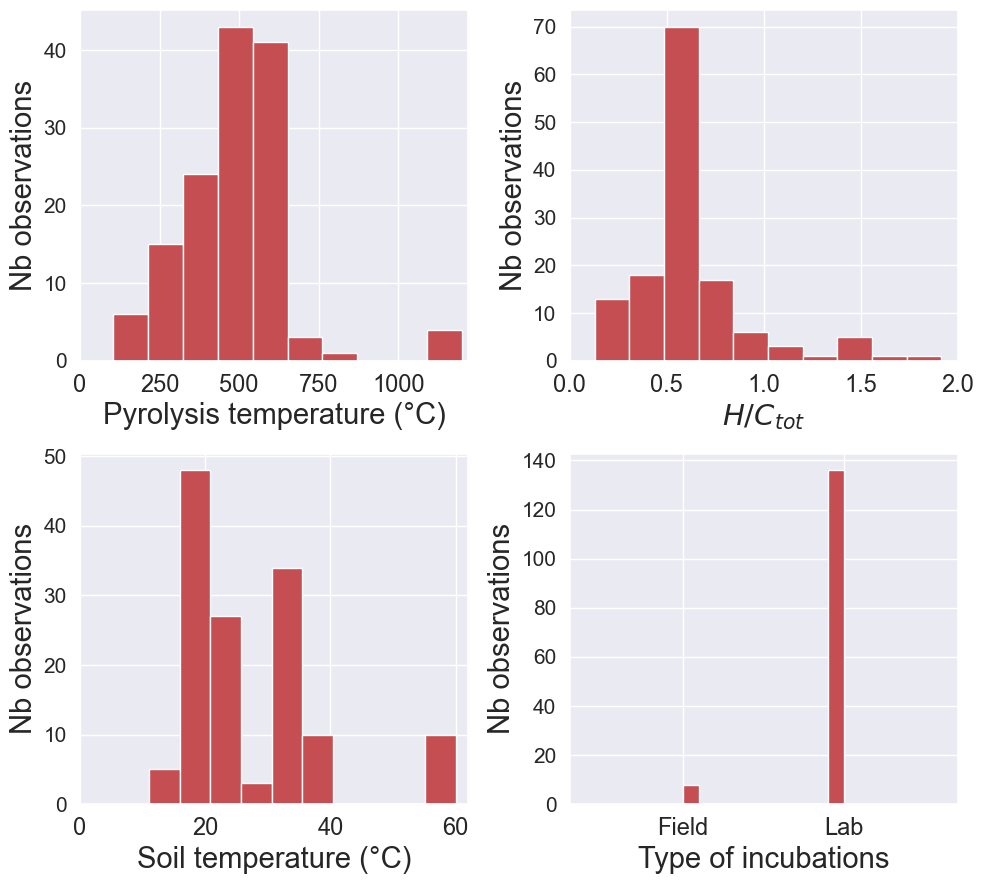

In [188]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,9))
axl = ax.ravel()
ts = 21
i=0
(metadata.replace(['na'], np.nan)['HHT']).hist(color='r', ax = axl[i])
axl[i].set_xlabel('Pyrolysis temperature (°C)', size=ts)
axl[i].set_ylabel('Nb observations', size=ts);
axl[i].set_xlim(0, 1200+20);
axl[i].tick_params(axis='x', which='major', labelsize=17)
axl[i].tick_params(axis='y', which='major', labelsize=15)

i=1
(metadata.replace(['na'], np.nan)['H/C_tot']).hist(color='r', ax = axl[i])
axl[i].set_xlabel(r'$H/C_{tot}$', size=ts)
axl[i].set_ylabel('Nb observations', size=ts)
axl[i].set_xlim(0, 2);
axl[i].tick_params(axis='x', which='major', labelsize=17)
axl[i].tick_params(axis='y', which='major', labelsize=15)

i=2
(metadata.replace(['na'], np.nan)['IncubationTemperature']).hist(color='r', ax = axl[i])
axl[i].set_xlabel('Soil temperature (°C)', size=ts)
axl[i].set_ylabel('Nb observations', size=ts);
axl[i].set_xlim(0, 60+2);
axl[i].tick_params(axis='x', which='major', labelsize=17)
axl[i].tick_params(axis='y', which='major', labelsize=15)

i=3
tmp = (metadata.replace(['na', 'nan'], np.nan)['LabField'])
tmp.hist(color='r', ax = axl[i], )
axl[i].margins(x=0.7)
axl[i].set_xlabel('Type of incubations', size=ts)
axl[i].set_ylabel('Nb observations', size=ts);
axl[i].tick_params(axis='x', which='major', labelsize=17)
axl[i].tick_params(axis='y', which='major', labelsize=15)

fig.tight_layout()
plt.savefig('simulations/manuscript/histograms-data-gaps.png', dpi=600)

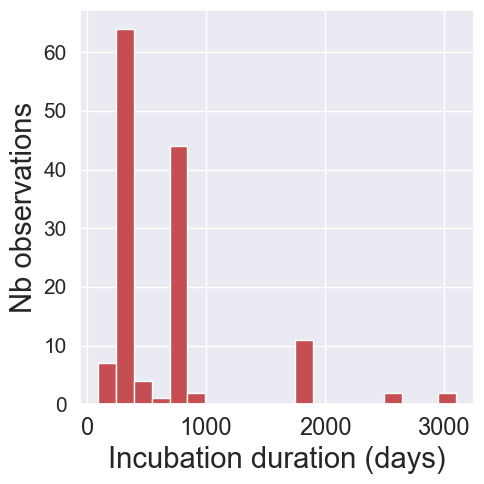

In [201]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

ts = 21
i=0
(metadata.replace(['na'], np.nan)['IncubationDuration']).plot.hist(color='r', ax = ax, bins=20)
ax.set_xlabel('Incubation duration (days)', size=ts)
ax.set_ylabel('Nb observations', size=ts);
#ax.set_xlim(0, 1200+20);
ax.tick_params(axis='x', which='major', labelsize=17)
ax.tick_params(axis='y', which='major', labelsize=15)


fig.tight_layout()
plt.savefig('simulations/manuscript/histograms-incubation-duration.png', dpi=600)

### Fig. Data gaps histograms

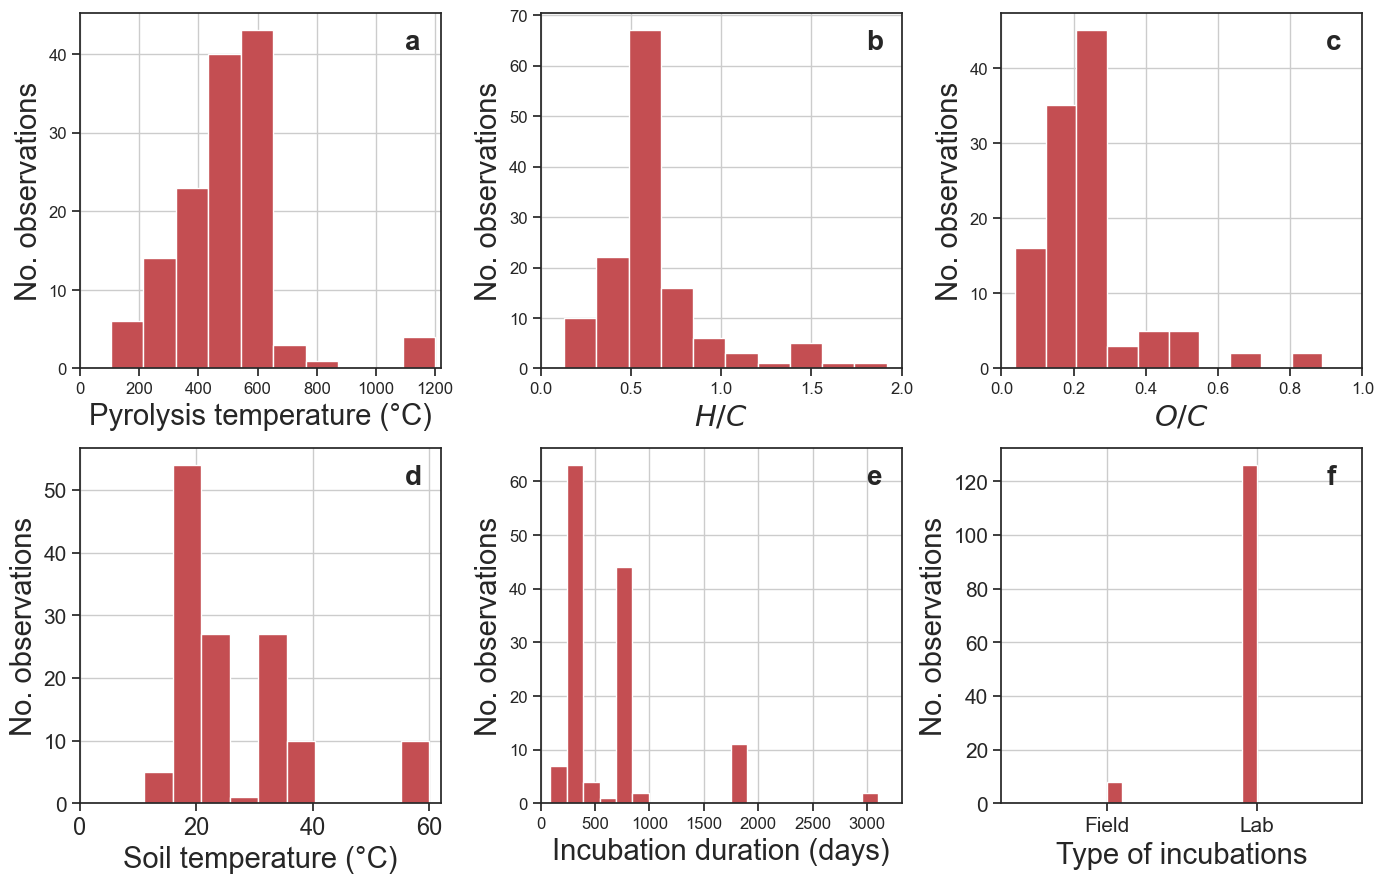

In [35]:
sns.set_style('ticks')
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,9))
axl = ax.ravel()
ts = 21
# drop rows for which no-incubation data available, to get total counts to 123+5
obs_with_data = data['ID_obs'].unique() # altough 2 obs without important series
to_drop = list(set(metadata.index) - set(obs_with_data))
met = metadata.drop(to_drop, inplace=False, axis=0)

i=0
(met.replace(['na'], np.nan)['HHT']).hist(color='r', ax = axl[i])
axl[i].set_xlabel('Pyrolysis temperature (°C)', size=ts)
axl[i].set_ylabel('No. observations', size=ts);
axl[i].set_xlim(0, 1200+20);
#axl[i].tick_params(axis='x', which='major', labelsize=17, direction='out', length=6, top=False)
#axl[i].tick_params(axis='y', which='major', labelsize=15)
#axl[i].tick_params(axis='x', which='both', colors='black', direction='inout', length=10)
axl[i].tick_params(which="both", bottom=True, labelsize=12)

axl[i].text(0.9, 0.90, string.ascii_lowercase[i], transform=axl[i].transAxes, size=20, weight='bold')
        
i=1
met.replace(['na'], np.nan, inplace=True)
met['H/C_all'] = met['H/C_org'].fillna(met['H/C_tot'], inplace=False)
met['H/C_all'].hist(color='r', ax = axl[i])
axl[i].set_xlabel(r'$H/C$', size=ts)
axl[i].set_ylabel('No. observations', size=ts);
axl[i].set_xlim(0, 2);
#axl[i].tick_params(axis='x', which='major', labelsize=17)
#axl[i].tick_params(axis='y', which='major', labelsize=15)
axl[i].tick_params(which="both", bottom=True, labelsize=12)
axl[i].text(0.9, 0.90, string.ascii_lowercase[i], transform=axl[i].transAxes, size=20, weight='bold')

i=2
(met.replace(['na'], np.nan)['O/C_org']).hist(color='r', ax = axl[i])
axl[i].set_xlabel(r'$O/C$', size=ts)
axl[i].set_ylabel('No. observations', size=ts);
axl[i].set_xlim(0, 1.);
#axl[i].tick_params(axis='x', which='major', labelsize=17)
#axl[i].tick_params(axis='y', which='major', labelsize=15)
axl[i].tick_params(which="both", bottom=True, labelsize=12)
axl[i].text(0.9, 0.90, string.ascii_lowercase[i], transform=axl[i].transAxes, size=20, weight='bold')

i=3
(met.replace(['na'], np.nan)['IncubationTemperature']).hist(color='r', ax = axl[i])
axl[i].set_xlabel('Soil temperature (°C)', size=ts)
axl[i].set_ylabel('No. observations', size=ts);
axl[i].set_xlim(0, 60+2);
axl[i].tick_params(axis='x', which='major', labelsize=17)
axl[i].tick_params(axis='y', which='major', labelsize=15)
axl[i].text(0.9, 0.90, string.ascii_lowercase[i], transform=axl[i].transAxes, size=20, weight='bold')

i=4
(met.replace(['na'], np.nan)['IncubationDuration']).plot.hist(color='r', ax = axl[i], bins=20)
axl[i].set_xlabel('Incubation duration (days)', size=ts)
axl[i].set_ylabel('No. observations', size=ts);
axl[i].set_xlim(0, 3300+20);
#axl[i].tick_params(axis='x', which='major', labelsize=17)
#axl[i].tick_params(axis='y', which='major', labelsize=15)
axl[i].tick_params(which="both", bottom=True, labelsize=12)
axl[i].grid(visible=True)
axl[i].text(0.9, 0.90, string.ascii_lowercase[i], transform=axl[i].transAxes, size=20, weight='bold')

i=5
tmp = (met.replace(['na', 'nan'], np.nan)['LabField'])
tmp.hist(color='r', ax = axl[i], )
axl[i].margins(x=0.7)
axl[i].set_xlabel('Type of incubations', size=ts)
axl[i].set_ylabel('No. observations', size=ts);
#axl[i].tick_params(axis='x', which='major', labelsize=17)
#axl[i].tick_params(axis='y', which='major', labelsize=15)
axl[i].tick_params(which="both", bottom=True, labelsize=15)
axl[i].text(0.9, 0.90, string.ascii_lowercase[i], transform=axl[i].transAxes, size=20, weight='bold')

fig.tight_layout()
plt.savefig('../simulations/manuscript/Figure4_histograms-data-gaps.png', dpi=600)

### Fig. Ternary HCO

C:\anaconda\envs\bw2\lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
C:\anaconda\envs\bw2\lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
C:\anaconda\envs\bw2\lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
C:\anaconda\envs\bw2\lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


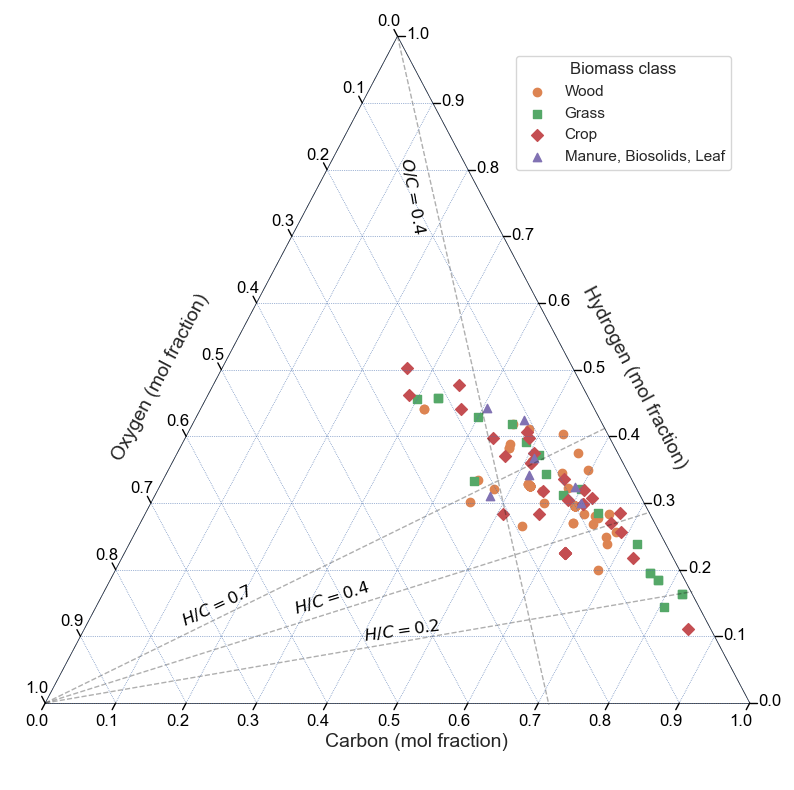

In [34]:
cols = ["BiomassClass", 'Carbon', 'Carbon, organic', 'Hydrogen', 'Oxygen']
ternary = metadata.replace(['na'], np.nan)[cols].copy(deep=True)

# conversion from %weight to mol fractions (so it reflects molar ratios) 
# %weight = g X /g biochar
# %mol = mol X / mol (X+Y+Z) 
# conversion is: %weight / M_X = mol X / g biochar /
M_C = 12.0107
M_H = 1.00784
M_O = 15.999

# fill C_org by C if C_org is nan
#ternary['Carbon'] = ternary['Carbon'] / M_C
ternary['Carbon, all'] = ternary['Carbon, organic'].fillna(ternary['Carbon'], inplace=False)
ternary['Carbon, all'] = ternary['Carbon, all'] / M_C

ternary['Hydrogen'] = ternary['Hydrogen'] / M_H
ternary['Oxygen'] = ternary['Oxygen'] / M_O
ternary['sum_HOC'] = ternary['Oxygen'] + ternary['Hydrogen'] + ternary['Carbon']
ternary['sum_HOC_org'] = ternary['Oxygen'] + ternary['Hydrogen'] + ternary['Carbon, organic']
ternary['sum_HOC_all'] = ternary['Oxygen'] + ternary['Hydrogen'] + ternary['Carbon, all']

ternary['Carbon, all'] = ternary['Carbon, all'] / ternary['sum_HOC_all'] * 100
ternary['Hydrogen'] = ternary['Hydrogen'] / ternary['sum_HOC_all'] * 100
ternary['Oxygen'] = ternary['Oxygen'] / ternary['sum_HOC_all'] * 100

# https://github.com/marcharper/python-ternary
fig, tax = ter.figure(scale=1)
fig.set_size_inches(10, 10)

# Draw ternary, by biomass class
tax.scatter(ternary[ternary['BiomassClass']=='wood'][['Carbon, all', 'Hydrogen', 'Oxygen']].values/100, label='Wood', marker='o')
tax.scatter(ternary[ternary['BiomassClass']=='grass'][['Carbon, all', 'Hydrogen', 'Oxygen']].values/100, label='Grass', marker='s')
tax.scatter(ternary[ternary['BiomassClass']=='crop'][['Carbon, all', 'Hydrogen', 'Oxygen']].values/100, label='Crop', marker='D')
#tax.scatter(ternary[ternary['BiomassClass']=='leaf'][['Carbon', 'Hydrogen', 'Oxygen']].values/100, label='Leaf', marker='^')
tax.scatter(ternary[ternary['BiomassClass'].isin(['biosolids', 'manure', 'leaf']) ][['Carbon, all', 'Hydrogen', 'Oxygen']].values/100,
            label='Manure, Biosolids, Leaf', marker='^')

# Draw some lines.
cc = 0.59
p1, p2 = (0, 0, 1), (cc, cc*0.70, 1- cc-cc*0.4)
tax.line(p1, p2, linewidth=1, color='k', alpha=0.35, linestyle="--") # H/C = 0.7
tax.get_axes().text(0.19, 0.1, r"$H/C = 0.7$", color='black', rotation=25, fontsize=12) # r"$H/C_{org} = 0.7$"

cc = 0.715
p1, p2 = (0, 0, 1), (cc, cc*0.40, 1- cc-cc*0.4)
tax.line(p1, p2, linewidth=1, color='k', alpha=0.35, linestyle="--") # H/C = 0.4
tax.get_axes().text(0.35, 0.115, r"$H/C = 0.4$", color='black', rotation=17, fontsize=12)

cc = 0.835
p1, p2 = (0, 0, 1), (cc, cc*0.20, 1- cc-cc*0.4)
tax.line(p1, p2, linewidth=1, color='k', alpha=0.35, linestyle="--") # H/C = 0.2
tax.get_axes().text(0.45, 0.081, r"$H/C = 0.2$", color='black', rotation=8, fontsize=12)

cc = 0.716
p1, p2 = (0, 1, 0), (cc, 1-cc-cc*0.40, cc*0.4)
tax.line(p1, p2, linewidth=1, color='k', alpha=0.35, linestyle="--") # O/C = 0.4
tax.get_axes().text(0.5, 0.61, r"$O/C = 0.4$", color='black', rotation=-80, fontsize=12)


# Axis labels. (See below for corner labels.)
fontsize = 14
offset = 0.1
tax.left_axis_label("Oxygen (mol fraction)", fontsize=fontsize, offset=offset)
tax.right_axis_label("Hydrogen (mol fraction)", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("Carbon (mol fraction)", fontsize=fontsize, offset=-offset)

# Decoration.
tax.legend(title="Biomass class", bbox_to_anchor=(0.94, 0.95))

tax.set_background_color(color='white') #whitesmoke
#plt.Polygon(xy=np.array([ter.project_point(p=(1,0,0)), ter.project_point(p=(0,1,0)) , ter.project_point(p=(0,0,1)) ]),closed=True, color='black', zorder=5)

tax.boundary(linewidth=0.5)
tax.gridlines(multiple=0.1,) # color="grey"
tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f",fontsize=12)
shhh = tax.get_axes().axis('off')

if True:
    tax.savefig('../simulations/manuscript/FigureS7_metadata_ternary_HOC.png', dpi=600, bbox_inches='tight')

C:\anaconda\envs\bw2\lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
C:\anaconda\envs\bw2\lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
C:\anaconda\envs\bw2\lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
C:\anaconda\envs\bw2\lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


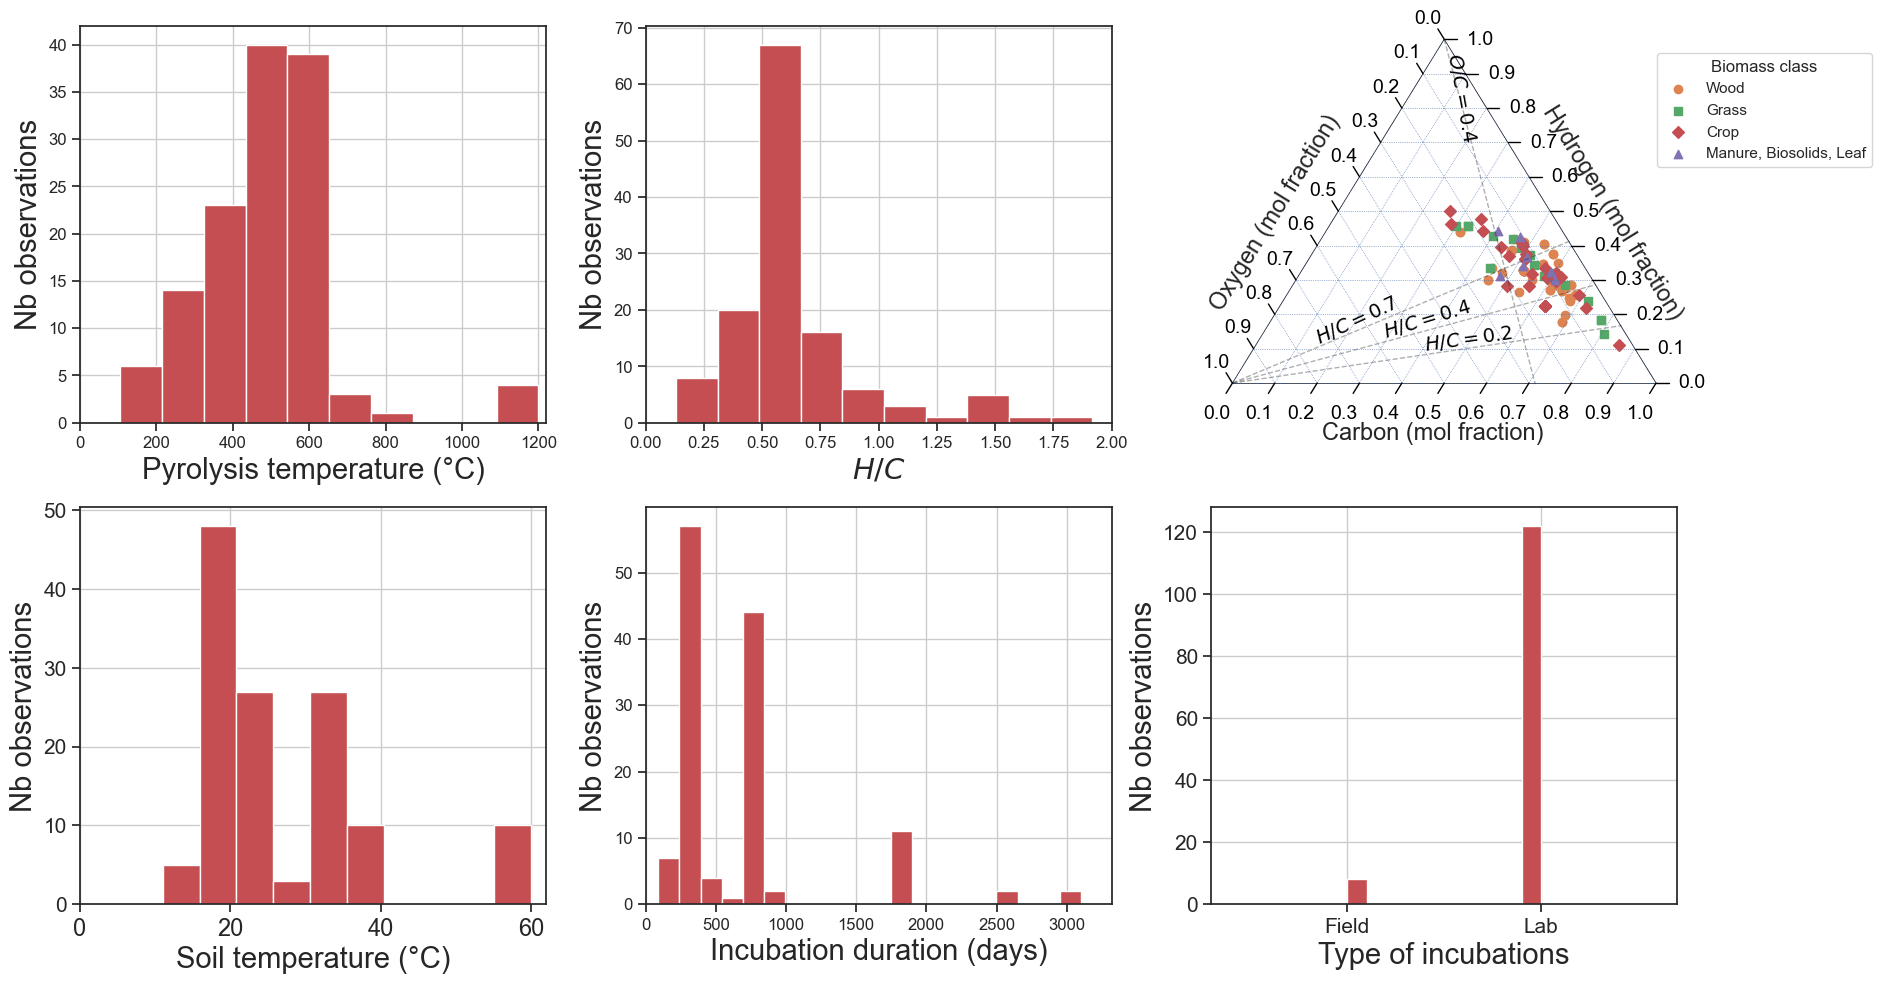

In [163]:
sns.set_style('ticks')
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(19,10))
axl = ax.ravel()
ts = 21
# drop rows for which no-incubation data available, to get total counts to 123+5
obs_with_data = data['ID_obs'].unique() # altough 2 obs without important series
to_drop = list(set(metadata.index) - set(obs_with_data))
met = metadata.drop(to_drop, inplace=False, axis=0)

i=0
(met.replace(['na'], np.nan)['HHT']).hist(color='r', ax = axl[i])
axl[i].set_xlabel('Pyrolysis temperature (°C)', size=ts)
axl[i].set_ylabel('Nb observations', size=ts);
axl[i].set_xlim(0, 1200+20);
#axl[i].tick_params(axis='x', which='major', labelsize=17, direction='out', length=6, top=False)
#axl[i].tick_params(axis='y', which='major', labelsize=15)
#axl[i].tick_params(axis='x', which='both', colors='black', direction='inout', length=10)
axl[i].tick_params(which="both", bottom=True, labelsize=12)

i=1
met.replace(['na'], np.nan, inplace=True)
met['H/C_all'] = met['H/C_org'].fillna(met['H/C_tot'], inplace=False)
met['H/C_all'].hist(color='r', ax = axl[i])
axl[i].set_xlabel(r'$H/C$', size=ts)
axl[i].set_ylabel('Nb observations', size=ts)
axl[i].set_xlim(0, 2);
#axl[i].tick_params(axis='x', which='major', labelsize=17)
#axl[i].tick_params(axis='y', which='major', labelsize=15)
axl[i].tick_params(which="both", bottom=True, labelsize=12)

i=3
(met.replace(['na'], np.nan)['IncubationTemperature']).hist(color='r', ax = axl[i])
axl[i].set_xlabel('Soil temperature (°C)', size=ts)
axl[i].set_ylabel('Nb observations', size=ts);
axl[i].set_xlim(0, 60+2);
axl[i].tick_params(axis='x', which='major', labelsize=17)
axl[i].tick_params(axis='y', which='major', labelsize=15)

i=4
(met.replace(['na'], np.nan)['IncubationDuration']).plot.hist(color='r', ax = axl[i], bins=20)
axl[i].set_xlabel('Incubation duration (days)', size=ts)
axl[i].set_ylabel('Nb observations', size=ts);
axl[i].set_xlim(0, 3300+20);
#axl[i].tick_params(axis='x', which='major', labelsize=17)
#axl[i].tick_params(axis='y', which='major', labelsize=15)
axl[i].tick_params(which="both", bottom=True, labelsize=12)
axl[i].grid(visible=True)

i=5
tmp = (met.replace(['na', 'nan'], np.nan)['LabField'])
tmp.hist(color='r', ax = axl[i], )
axl[i].margins(x=0.7)
axl[i].set_xlabel('Type of incubations', size=ts)
axl[i].set_ylabel('Nb observations', size=ts);
#axl[i].tick_params(axis='x', which='major', labelsize=17)
#axl[i].tick_params(axis='y', which='major', labelsize=15)
axl[i].tick_params(which="both", bottom=True, labelsize=15)

# ternary
cols = ["BiomassClass", 'Carbon', 'Carbon, organic', 'Hydrogen', 'Oxygen']
ternary = metadata.replace(['na'], np.nan)[cols].copy(deep=True)

# conversion from %weight to mol fractions (so it reflects molar ratios) 
# %weight = g X /g biochar
# %mol = mol X / mol (X+Y+Z) 
# conversion is: %weight / M_X = mol X / g biochar /
M_C = 12.0107
M_H = 1.00784
M_O = 15.999

# fill C_org by C if C_org is nan
#ternary['Carbon'] = ternary['Carbon'] / M_C
ternary['Carbon, all'] = ternary['Carbon, organic'].fillna(ternary['Carbon'], inplace=False)
ternary['Carbon, all'] = ternary['Carbon, all'] / M_C

ternary['Hydrogen'] = ternary['Hydrogen'] / M_H
ternary['Oxygen'] = ternary['Oxygen'] / M_O
ternary['sum_HOC'] = ternary['Oxygen'] + ternary['Hydrogen'] + ternary['Carbon']
ternary['sum_HOC_org'] = ternary['Oxygen'] + ternary['Hydrogen'] + ternary['Carbon, organic']
ternary['sum_HOC_all'] = ternary['Oxygen'] + ternary['Hydrogen'] + ternary['Carbon, all']

ternary['Carbon, all'] = ternary['Carbon, all'] / ternary['sum_HOC_all'] * 100
ternary['Hydrogen'] = ternary['Hydrogen'] / ternary['sum_HOC_all'] * 100
ternary['Oxygen'] = ternary['Oxygen'] / ternary['sum_HOC_all'] * 100

# https://github.com/marcharper/python-ternary
tax = ter.TernaryAxesSubplot(scale=1., ax=axl[2])

# Draw ternary, by biomass class
tax.scatter(ternary[ternary['BiomassClass']=='wood'][['Carbon, all', 'Hydrogen', 'Oxygen']].values/100, label='Wood', marker='o')
tax.scatter(ternary[ternary['BiomassClass']=='grass'][['Carbon, all', 'Hydrogen', 'Oxygen']].values/100, label='Grass', marker='s')
tax.scatter(ternary[ternary['BiomassClass']=='crop'][['Carbon, all', 'Hydrogen', 'Oxygen']].values/100, label='Crop', marker='D')
#tax.scatter(ternary[ternary['BiomassClass']=='leaf'][['Carbon', 'Hydrogen', 'Oxygen']].values/100, label='Leaf', marker='^')
tax.scatter(ternary[ternary['BiomassClass'].isin(['biosolids', 'manure', 'leaf']) ][['Carbon, all', 'Hydrogen', 'Oxygen']].values/100,
            label='Manure, Biosolids, Leaf', marker='^')

# Draw some lines.
cc = 0.59
p1, p2 = (0, 0, 1), (cc, cc*0.70, 1- cc-cc*0.4)
tax.line(p1, p2, linewidth=1, color='k', alpha=0.35, linestyle="--") # H/C = 0.7
tax.get_axes().text(0.19, 0.1, r"$H/C = 0.7$", color='black', rotation=25, fontsize=14) # r"$H/C_{org} = 0.7$"

cc = 0.715
p1, p2 = (0, 0, 1), (cc, cc*0.40, 1- cc-cc*0.4)
tax.line(p1, p2, linewidth=1, color='k', alpha=0.35, linestyle="--") # H/C = 0.4
tax.get_axes().text(0.35, 0.115, r"$H/C = 0.4$", color='black', rotation=17, fontsize=14)

cc = 0.835
p1, p2 = (0, 0, 1), (cc, cc*0.20, 1- cc-cc*0.4)
tax.line(p1, p2, linewidth=1, color='k', alpha=0.35, linestyle="--") # H/C = 0.2
tax.get_axes().text(0.45, 0.081, r"$H/C = 0.2$", color='black', rotation=8, fontsize=14)

cc = 0.716
p1, p2 = (0, 1, 0), (cc, 1-cc-cc*0.40, cc*0.4)
tax.line(p1, p2, linewidth=1, color='k', alpha=0.35, linestyle="--") # O/C = 0.4
tax.get_axes().text(0.5, 0.61, r"$O/C = 0.4$", color='black', rotation=-80, fontsize=14)


# Axis labels. (See below for corner labels.)
fontsize = 17
offset = 0.15
tax.left_axis_label("Oxygen (mol fraction)", fontsize=fontsize, offset=offset)
tax.right_axis_label("Hydrogen (mol fraction)", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("Carbon (mol fraction)", fontsize=fontsize, offset=0.1)

# Decoration.
tax.legend(title="Biomass class", bbox_to_anchor=(0.94, 0.95))

tax.set_background_color(color='white') #whitesmoke
#plt.Polygon(xy=np.array([ter.project_point(p=(1,0,0)), ter.project_point(p=(0,1,0)) , ter.project_point(p=(0,0,1)) ]),closed=True, color='black', zorder=5)

tax.boundary(linewidth=0.5)
tax.gridlines(multiple=0.1,) # color="grey"
tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f",fontsize=14, offset=0.03)
shhh = tax.get_axes().axis('off')

fig.tight_layout()
#plt.savefig('simulations/manuscript/histograms-data-gaps.png', dpi=600)

### Pyrolysis

In [27]:
obs_with_data = data['ID_obs'].unique() # altough 2 obs without important series
to_drop = list(set(metadata.index) - (set(obs_with_data) - {39, 111}))
metadata = metadata.drop(to_drop, inplace=False, axis=0)

In [28]:
metadata['PyrolysisClass'].value_counts()

pyr-slow     122
no-treat       5
gas            4
htc            2
pyr-flash      1
Name: PyrolysisClass, dtype: int64

In [29]:
metadata['PyrolysisClass'].value_counts()/(metadata['PyrolysisClass'].value_counts().sum()-5)*100

pyr-slow     94.573643
no-treat      3.875969
gas           3.100775
htc           1.550388
pyr-flash     0.775194
Name: PyrolysisClass, dtype: float64

In [31]:
ooo = metadata.replace(['na'], np.nan)['HR']
print(  '{:0.1f}, {:0.1f}, {:0.1f} ({:0.0f}) '.format(ooo.min(), ooo.median(), ooo.max(), len(ooo))   )
ooo.mode()

0.1, 7.5, 51.0 (134) 


0    7.5
Name: HR, dtype: float64

In [32]:
ooo = metadata.replace(['na'], np.nan)['RT']
print(  '{:0.1f}, {:0.1f}, {:0.1f} ({:0.0f}) '.format(ooo.min(), ooo.median(), ooo.max(), len(ooo))   )
ooo.mode()

0.0, 40.0, 4320.0 (134) 


0    40.0
Name: RT, dtype: float64

### Biochar

In [36]:
# range H/C_all
metadata.replace(['na'], np.nan, inplace=True)
metadata['H/C_all'] = metadata['H/C_org'].fillna(metadata['H/C_tot'], inplace=False)
ooo = metadata[(metadata['PyrolysisClass'] != 'no-treat')
              ]['H/C_all']  
print(  '{:0.2f}, {:0.2f}, {:0.2f} ({:0.0f}) '.format(ooo.min(), ooo.median(), ooo.max(), len(ooo))   )


0.13, 0.54, 1.40 (129) 


In [37]:
# H/C below 0.2
metadata.replace(['na'], np.nan, inplace=True)
metadata['H/C_all'] = metadata['H/C_org'].fillna(metadata['H/C_tot'], inplace=False)
ooo = metadata[(metadata['PyrolysisClass'] != 'no-treat')
               & (metadata['H/C_all'] <= 0.2)
              ]['H/C_all']  
print(  '{:0.2f}, {:0.2f}, {:0.2f} ({:0.0f}) '.format(ooo.min(), ooo.median(), ooo.max(), len(ooo))   )


0.13, 0.19, 0.20 (4) 


In [38]:
# ash & pH
metadata.replace(['na'], np.nan, inplace=True)
ooo = metadata[(metadata['PyrolysisClass'] != 'no-treat')
              ]['pH_H2O']  
print('pH', '{:0.2f}, {:0.2f}, {:0.2f} ({:0.0f}) '.format(ooo.min(), ooo.median(), ooo.max(), len(ooo))   )
ooo = metadata[(metadata['PyrolysisClass'] != 'no-treat')
              ]['Ash550'] * 100 
print('Ash550', '{:0.2f}, {:0.2f}, {:0.2f} ({:0.0f}) '.format(ooo.min(), ooo.median(), ooo.max(), len(ooo))   )
ooo = metadata[(metadata['PyrolysisClass'] != 'no-treat')
              ]['Ash700'] * 100
print('Ash700', '{:0.2f}, {:0.2f}, {:0.2f} ({:0.0f}) '.format(ooo.min(), ooo.median(), ooo.max(), len(ooo))   )

pH 3.90, 9.40, 10.79 (129) 
Ash550 1.50, 7.00, 76.20 (129) 
Ash700 0.30, 6.80, 75.70 (129) 


In [39]:
metadata.replace(['na'], np.nan)['OxidationH2O2'].isnull().value_counts()
# only 10 measurements of Oxidation, out of 125, and with different methods 

True     123
False     11
Name: OxidationH2O2, dtype: int64

### Incubation conditions

In [40]:
obs_with_data = data['ID_obs'].unique() # altough 2 obs without important series
to_drop = list(set(metadata.index) - (set(obs_with_data) - {39, 111}))
metadata = metadata.drop(to_drop, inplace=False, axis=0)
metadata['LabField'].value_counts()

Lab      126
Field      8
Name: LabField, dtype: int64

In [42]:
ooo = metadata[(metadata['PyrolysisClass'] != 'no-treat')
              ]['IncubationDuration']
print('Duration', '{:0.2f}, {:0.2f}, {:0.2f} ({:0.0f}) '.format(ooo.min(), ooo.median(), ooo.max(), len(ooo))   )
ooo.mode()

Duration 90.00, 390.00, 3102.00 (129) 


0    365.0
Name: IncubationDuration, dtype: float64

In [43]:
metadata['IncubationDuration'].mode()

0    365.0
Name: IncubationDuration, dtype: float64

In [44]:
ooo = metadata[(metadata['PyrolysisClass'] != 'no-treat')
              ]['pH_soil']  
ooo = ooo.replace(['na', ''], np.nan)
print('pH soil', '{:0.2f}, {:0.2f}, {:0.2f} ({:0.0f}) '.format(ooo.min(), ooo.median(), ooo.max(), len(ooo))   )


pH soil 4.64, 6.80, 8.77 (129) 


In [45]:
ooo = metadata[(metadata['PyrolysisClass'] != 'no-treat')
              ]['Soil organic matter content']  
ooo = ooo.replace(['na', ''], np.nan)
print('soil OM', '{:0.2f}, {:0.2f}, {:0.2f} ({:0.0f}) '.format(ooo.min(), ooo.median(), ooo.max(), len(ooo))   )


soil OM 0.00, 0.02, 0.18 (129) 


C:\anaconda\envs\bw2\lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


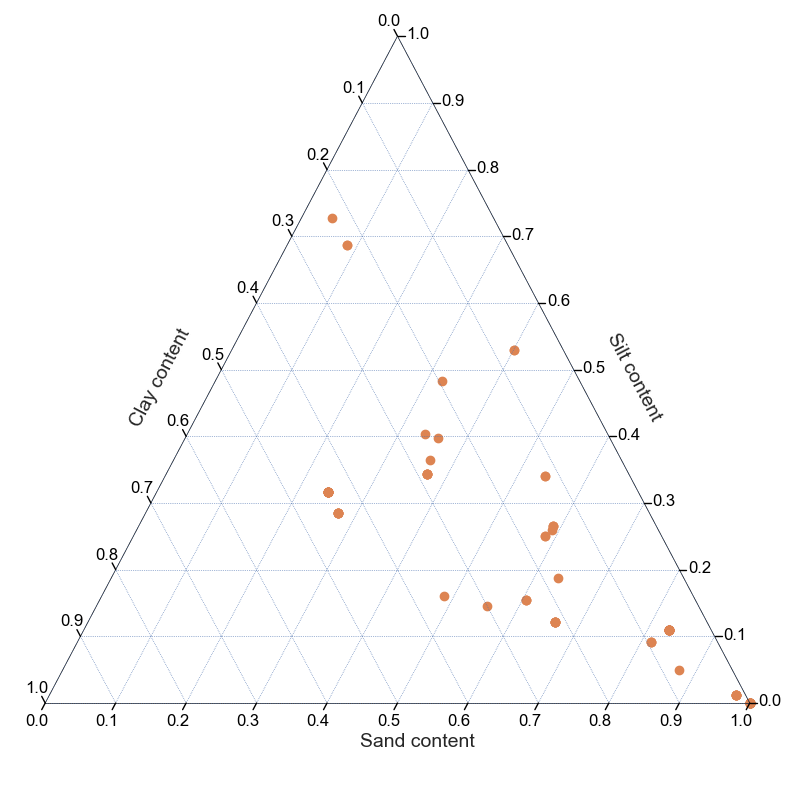

In [46]:
# Soil textures that have been incubated

cols = ["Soil sand content", 'Soil silt content', 'Soil clay content']
ternary = metadata.replace(['na', ''], np.nan)[cols].copy(deep=True)
ternary['sum_Texture'] = ternary['Soil sand content'] + ternary['Soil silt content'] + ternary['Soil clay content'] 
ternary['Soil sand content'] = ternary['Soil sand content'] / ternary['sum_Texture']
ternary['Soil silt content'] = ternary['Soil silt content'] / ternary['sum_Texture']
ternary['Soil clay content'] = ternary['Soil clay content'] / ternary['sum_Texture'] 

# https://github.com/marcharper/python-ternary
fig, tax = ter.figure(scale=1)
fig.set_size_inches(10, 10)

# Draw ternary, by biomass class
tax.scatter(ternary[['Soil sand content', 'Soil silt content', 'Soil clay content']].values,
            marker='o')

# Axis labels. (See below for corner labels.)
fontsize = 14
offset = 0.1
tax.left_axis_label("Clay content", fontsize=fontsize, offset=offset)
tax.right_axis_label("Silt content", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("Sand content", fontsize=fontsize, offset=-offset)

# Decoration.
#tax.legend(title="Biomass class", bbox_to_anchor=(0.94, 0.95))

tax.set_background_color(color='white') #whitesmoke
#plt.Polygon(xy=np.array([ter.project_point(p=(1,0,0)), ter.project_point(p=(0,1,0)) , ter.project_point(p=(0,0,1)) ]),closed=True, color='black', zorder=5)

tax.boundary(linewidth=0.5)
tax.gridlines(multiple=0.1,) # color="grey"
tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f",fontsize=12)
shhh = tax.get_axes().axis('off')

if True:
    tax.savefig('../simulations/manuscript/FigureS8_metadata_ternary_SoilTexture.png', dpi=300, bbox_inches='tight')

In [47]:
# Map
long = []
lat = []
for r, row in metadata.iterrows():
    s = metadata['SoilGeolocation'][r]
    if s == 'nan':
        lat.append(np.nan)
        long.append(np.nan)  
    else:
        s = s[1:-1]
        s = tuple(map(float, s.split(', ')))
        lat.append(s[0])
        long.append(s[1])

LatLong = pd.DataFrame({'lat':lat, 'long': long, 'LatLong': metadata['SoilGeolocation']})

uniqueLatLong = LatLong.value_counts().reset_index()
uniqueLatLong.rename(columns={0:'count'}, inplace=True)
len(uniqueLatLong), uniqueLatLong['count'].sum()

(23, 119)

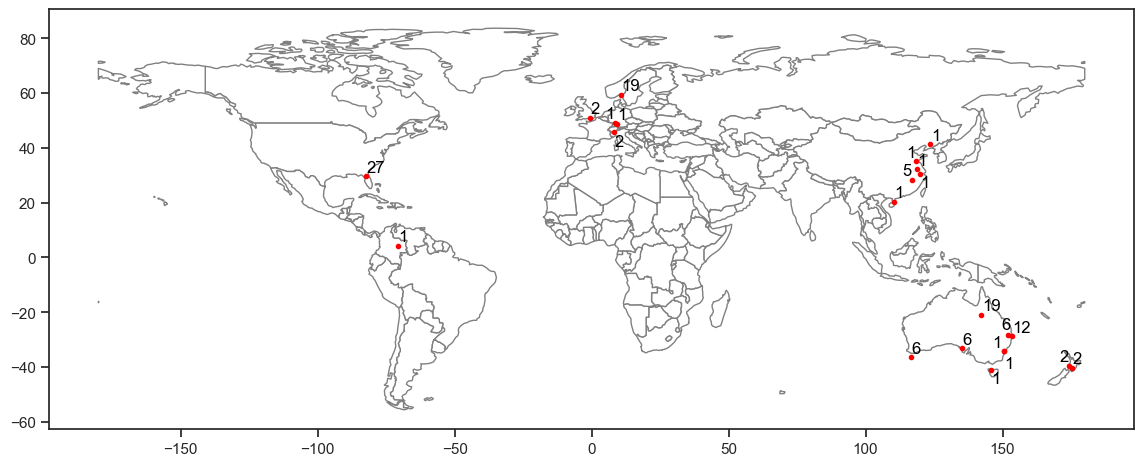

In [48]:
gdf = gpd.GeoDataFrame(
    uniqueLatLong, geometry=gpd.points_from_xy(uniqueLatLong.long, uniqueLatLong.lat))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.drop(world.index[159]) # antartica row dropped

# We restrict to South America.
ax = world.plot(color='white', edgecolor='grey', figsize=(14,14))
# We can now plot our ``GeoDataFrame``.

gdf.plot(ax=ax, color='red', marker='.')
#ax.annotate('bb', xy=(0,0), color='black')
texts = []
for r, row in uniqueLatLong.iterrows():
    texts.append(ax.annotate(str(row['count']), xy=(row['long'], row['lat']), color='black', fontsize=12))

adjust_text(texts)

if True:
    plt.savefig('../simulations/manuscript/FigureS9_metadata_soilGeolocationMap.png', dpi=300, bbox_inches='tight')

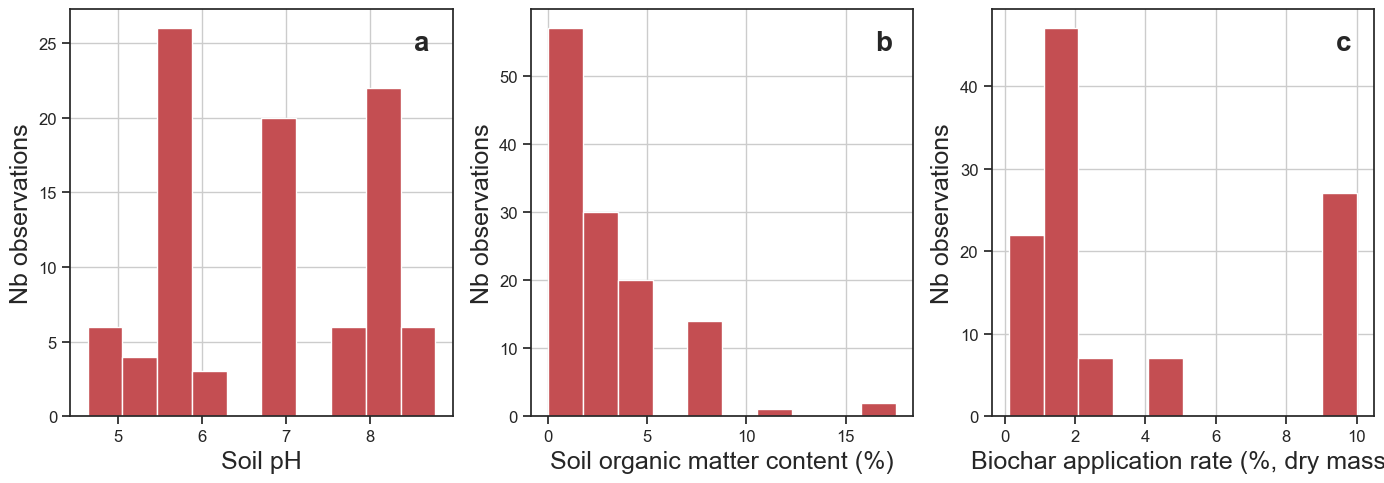

In [49]:
sns.set_style('ticks')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14,5))
axl = ax.ravel()
ts = 18

# drop rows for which no-incubation data available, to get total counts to 123+5
obs_with_data = data['ID_obs'].unique() # altough 2 obs without important series
to_drop = list(set(metadata.index) - set(obs_with_data))
met = metadata.drop(to_drop, inplace=False, axis=0)

i=0
(met.replace(['na', ''], np.nan)['pH_soil']).hist(color='r', ax = axl[i])
axl[i].set_xlabel('Soil pH', size=ts)
axl[i].set_ylabel('Nb observations', size=ts);
#axl[i].set_xlim(0, 1200+20);
#axl[i].tick_params(axis='x', which='major', labelsize=17, direction='out', length=6, top=False)
#axl[i].tick_params(axis='y', which='major', labelsize=15)
#axl[i].tick_params(axis='x', which='both', colors='black', direction='inout', length=10)
axl[i].tick_params(which="both", bottom=True, labelsize=12)

axl[i].text(0.9, 0.90, string.ascii_lowercase[i], transform=axl[i].transAxes, size=20, weight='bold')
        
i=1
(met.replace(['na', ''], np.nan)['Soil organic matter content']*100).hist(color='r', ax = axl[i])
axl[i].set_xlabel(r'Soil organic matter content (%)', size=ts)
axl[i].set_ylabel('Nb observations', size=ts)
#axl[i].set_xlim(0, 2);
#axl[i].tick_params(axis='x', which='major', labelsize=17)
#axl[i].tick_params(axis='y', which='major', labelsize=15)
axl[i].tick_params(which="both", bottom=True, labelsize=12)
axl[i].text(0.9, 0.90, string.ascii_lowercase[i], transform=axl[i].transAxes, size=20, weight='bold')

i=2
(met.replace(['na', '', 'tbd'], np.nan)['ApplicationRate']*100).hist(color='r', ax = axl[i])
axl[i].set_xlabel(r'Biochar application rate (%, dry mass)', size=ts)
axl[i].set_ylabel('Nb observations', size=ts)
#axl[i].set_xlim(0, 1.);
#axl[i].tick_params(axis='x', which='major', labelsize=17)
#axl[i].tick_params(axis='y', which='major', labelsize=15)
axl[i].tick_params(which="both", bottom=True, labelsize=12)
axl[i].text(0.9, 0.90, string.ascii_lowercase[i], transform=axl[i].transAxes, size=20, weight='bold')

fig.tight_layout()
plt.savefig('../simulations/manuscript/FigureS10_histograms-soil-properties.png', dpi=600)

## Dataset correlations

Correlation calculation and interpertation will not be the same:
- between numerical variables
- between categorical variables (https://www.statology.org/correlation-between-categorical-variables/)
- between a numerical and a categorical variable (https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance and ANOVA)

For now, we limit ourselves to correlation between numerical variables. The categorical variables are plotted on top of the scatter plots (biomass class as marker type, pyrolysis type as marker color, with annotation of the article).

In addition, let's note that:
- correlation as determined by Pearson method corresponds to a linear correlation, the coefficient correspond to the slope of the best line fitting the two variables, and therefore vary between -1 and +1.
- Pearson correlation is not well suited to identify non-linear correlations
- other methods for non-linear correlation include e.g. the distance correlation (by SZÉKELY, 2007); or the Maximal Information Coefficient (MIC, 2011, https://doi.org/10.1126%2Fscience.1205438), see examples https://www.freecodecamp.org/news/how-machines-make-predictions-finding-correlations-in-complex-data-dfd9f0d87889/ 
- Distance correlation (and MIC) are also suited for identifying linear correlations

Below, we implement:
- Pearson correlation (alt. also easily available via df.corr: pearson : standard correlation coefficient; kendall : Kendall Tau correlation coefficient; spearman : Spearman rank correlation)
- Distance correlation (via scipy and dcor package)



In [51]:
fp = '../biocharStability/database/biochar_incubation_database_2022-03-22_live.xlsx'
metadata, schema, metadata_column_sets = bs.load_metadata(filepath=fp)

Metadata loaded, with 187 rows


In [52]:
# numerical variables, including boolean, int, 
info_cols = ['ID_art', 'NameObs', 'Replicates','Biomass', 'Pyrolysis', 'BiomassLignin', 'Soil type',
             'SoilMoisture_Absolute', 'SoilOrigin', 'SoilGeolocation', 'TotalFluxMeasurement', 'BiocharFluxDetermination', 'OtherIncubationDescription', 'AssociatedControl',
             'Cultivated', 'ID_Lehmann2019', 'ID_Woolf2021', 'ID_Lehmann2021',
             ]
col_to_drop = ['pH_bc-soil', 'Magnesium', 'Potassium', 'Phosphorous', 'ParticleSize', 'BulkDensity',
              'TrueDensity', 'OxidationH2O2', 'BiocharYield', 'δ ¹³C biochar',
              'δ ¹³C soil', 'FixedCarbon', 'VolatileMatter', 'pH_CaCl2', 'CEC', 'SA_N2', 'SA_CO2', 'Sulphur', 'ApplicationRate',]

col_categorical = ['BiomassClass', 'PyrolysisClass', 'LabField', 'AuthorDate']

col_numerical = ['HHT', 'RT', 'HR', 'Soil clay content', 'Soil sand content', 'Soil silt content', 'Soil organic matter content',
                'SoilMoisture_WHC', 'pH_soil', 'IncubationTemperature', 'IncubationDuration', 
                'Ash550', 'Ash700', 'Carbon', 'Carbon, organic', 'Hydrogen', 'Nitrogen',
                'Oxygen', 'H/C_org', 'H/C_tot', 'O/C_org', 'C/N', 'pH_H2O',
                ]
df = metadata.copy(deep=True)
df.drop(info_cols, axis=1, inplace=True)

# adding, dry ash-free elemental contents
dafs = ['Carbon', 'Carbon, organic', 'Hydrogen', 'Oxygen']
for d in dafs:
    df = bs.dry2daf(df, x=d, ash='Ash')

In [53]:
# exclude non-biochar obsevations
df = df[df['PyrolysisClass'] != 'no-treat']

### Pearson correlation, metadata

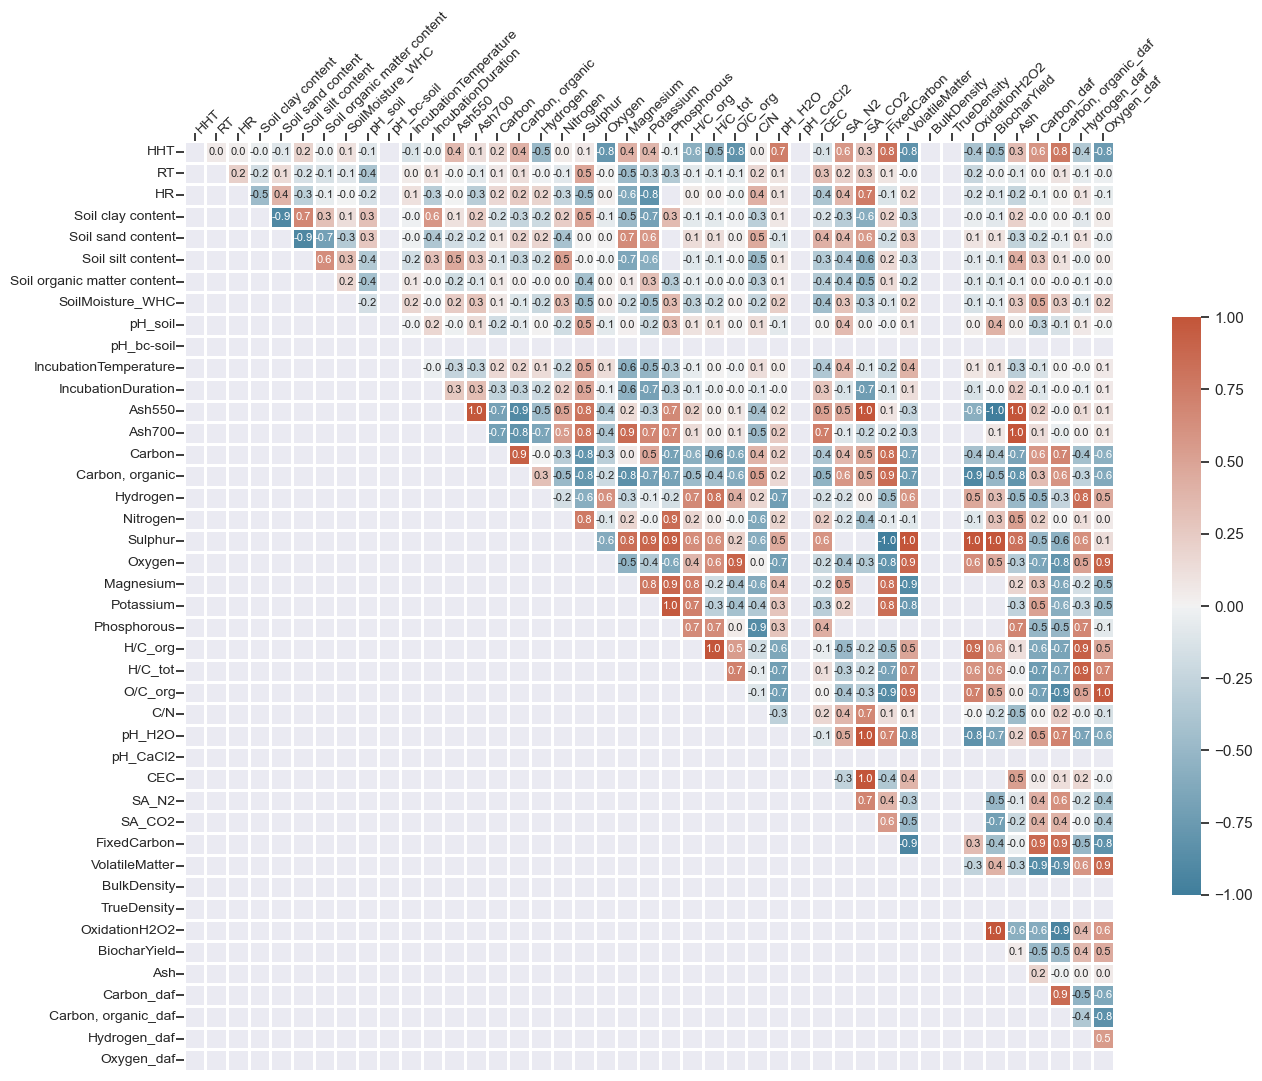

In [54]:
%matplotlib inline
with sns.axes_style("darkgrid"):
    # Correlation
    corr = df.corr(method='pearson', numeric_only=True)
    mask = np.triu(np.ones_like(corr, dtype=bool)).T
    meta_numeric = corr.columns

    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    #corr[['BC_50', 'BC_100', 'BC_150', 'BC_200']]
    sns.heatmap(corr, cmap=cmap, center=0, mask=mask,
                square=True, linewidths=.9, linecolor='white',
                cbar_kws={"shrink": .5},
                annot=True, annot_kws={"size": 8}, fmt='.1f')

    ax.tick_params(axis='both', which='major', labelsize=10, 
                   labelbottom = False, bottom=False, top = True, labeltop=True, left=True,
                   pad=0)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='left', verticalalignment='baseline',
                       parse_math=True);

plt.savefig('../simulations/manuscript/FigureS10_correlation-pearson-all-numerics.png', dpi=600, bbox_inches='tight')


### Distance correlation, metadata

In [55]:
# working with df_wSf [with ash free variables] and existing corr matrix (to extract names of numeric variables)
corr = df.corr(method='pearson', numeric_only=True)
dcorr = pd.DataFrame(columns=corr.columns, index=corr.index)
count=0
for x1, x2 in itertools.product(corr.index, corr.columns):
    shivesh = df[[x1,x2]].dropna()
    dcorr.loc[x1, x2] = dc.distance_correlation(shivesh[x1], shivesh[x2])
    #print(x1, x2, dcorr.loc[x1, x2])

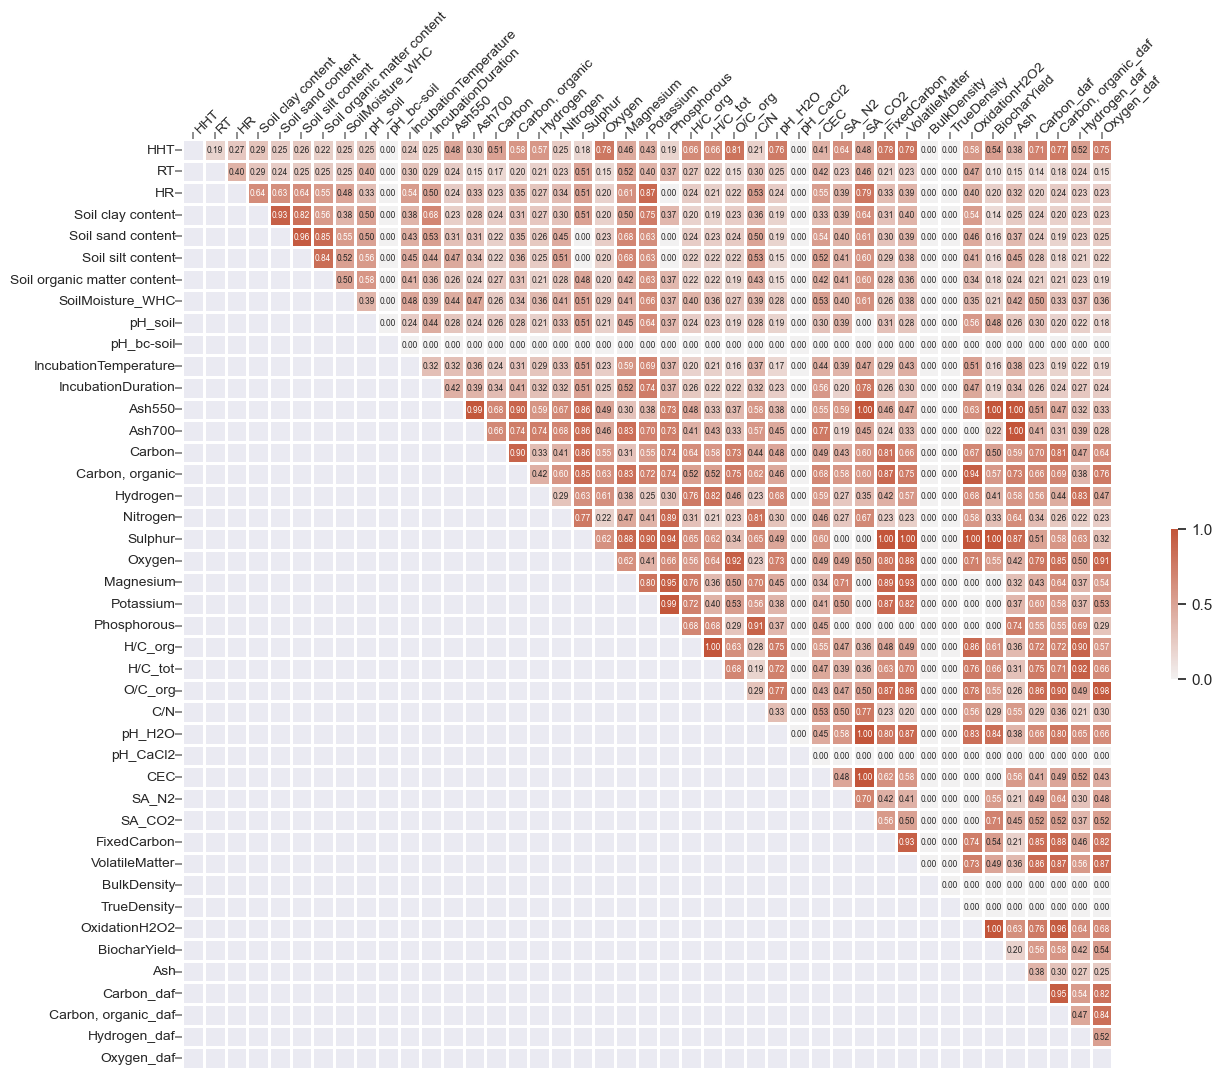

In [56]:
%matplotlib inline
with sns.axes_style("darkgrid"):
    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    dcorr = dcorr.astype(np.float64)

    tmp = dcorr[meta_numeric].T[meta_numeric]
    mask = np.triu(np.ones_like(tmp, dtype=bool)).T

    sns.heatmap(tmp, cmap=cmap, center=0, mask=mask,
                square=True, linewidths=.9, linecolor='white',
                cbar_kws={"shrink": 0.13}, annot=True, annot_kws={"size": 6}, fmt='.2f')

    ax.tick_params(axis='both', which='major', labelsize=10, 
                   labelbottom = False, bottom=False, top = True, labeltop=True, left=True,
                   color="grey", length=5, pad=0)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='left', verticalalignment='baseline',
                       parse_math=True);

plt.savefig('../simulations/manuscript/FigureS11_correlation-distance-all-numeric.png', dpi=300, bbox_inches='tight')
#plt.show()

### Correlation with decay variables 

In [57]:
# numerical variables, including boolean, int, 
info_cols = ['ID_art', 'NameObs', 'Replicates','Biomass', 'Pyrolysis', 'BiomassLignin', 'Soil type',
             'SoilMoisture_Absolute', 'SoilOrigin', 'SoilGeolocation', 'TotalFluxMeasurement', 'BiocharFluxDetermination', 'OtherIncubationDescription', 'AssociatedControl',
             'Cultivated', 'ID_Lehmann2019', 'ID_Woolf2021', 'ID_Lehmann2021',
             ]
col_to_drop = ['pH_bc-soil', 'Magnesium', 'Potassium', 'Phosphorous', 'ParticleSize', 'BulkDensity',
              'TrueDensity', 'OxidationH2O2', 'BiocharYield', 'δ ¹³C biochar',
              'δ ¹³C soil', 'FixedCarbon', 'VolatileMatter', 'pH_CaCl2', 'CEC', 'SA_N2', 'SA_CO2', 'Sulphur', 'ApplicationRate',]

col_categorical = ['BiomassClass', 'PyrolysisClass', 'LabField', 'AuthorDate']

col_numerical = ['HHT', 'RT', 'HR', 'Soil clay content', 'Soil sand content', 'Soil silt content', 'Soil organic matter content',
                'SoilMoisture_WHC', 'pH_soil', 'IncubationTemperature', 'IncubationDuration', 
                'Ash550', 'Ash700', 'Carbon', 'Carbon, organic', 'Hydrogen', 'Nitrogen',
                'Oxygen', 'H/C_org', 'H/C_tot', 'O/C_org', 'C/N', 'pH_H2O',
                ]
df = metadata.copy(deep=True)
df.drop(info_cols, axis=1, inplace=True)

# adding, dry ash-free elemental contents
dafs = ['Carbon', 'Carbon, organic', 'Hydrogen', 'Oxygen']
for d in dafs:
    df = bs.dry2daf(df, x=d, ash='Ash')

# total carbon loss
cum_loss = []
last_measured_time = []
for o in metadata.index:
    try:
        time,closs = bs.select_timeseries(o, data, col_to_plot='C_bc_loss_rel', factor=100)
        cum_loss.append(closs[-1])
        last_measured_time.append(time[-1])
    except Exception:
        #print("data missing for: ", o)
        cum_loss.append(np.nan)
        last_measured_time.append(np.nan)

df['Total C lost'] = cum_loss

# last measured decay rate and time for each observation
cum_loss = []
last_measured_time = []
for o in metadata.index:
    try:
        time,closs = bs.select_timeseries(o, data, col_to_plot='k_bc_rel0', factor=365)
        cum_loss.append(closs[-1])
        last_measured_time.append(time[-1])
    except Exception:
        #print("data missing for: ", o)
        cum_loss.append(np.nan)
        last_measured_time.append(np.nan)

df['Last measured decay rate'] = cum_loss

# exclude non-biochar obsevations
df = df[df['PyrolysisClass'] != 'no-treat']

In [58]:
# working with df_wSf [with ash free variables] and existing corr matrix (to extract names of numeric variables)
corr = df.corr(method='pearson', numeric_only=True)
dcorr = pd.DataFrame(columns=corr.columns, index=corr.index)
count=0
for x1, x2 in itertools.product(corr.index, corr.columns):
    shivesh = df[[x1,x2]].dropna()
    dcorr.loc[x1, x2] = dc.distance_correlation(shivesh[x1], shivesh[x2])
    #print(x1, x2, dcorr.loc[x1, x2])
    
dcorr = dcorr.astype(np.float64)

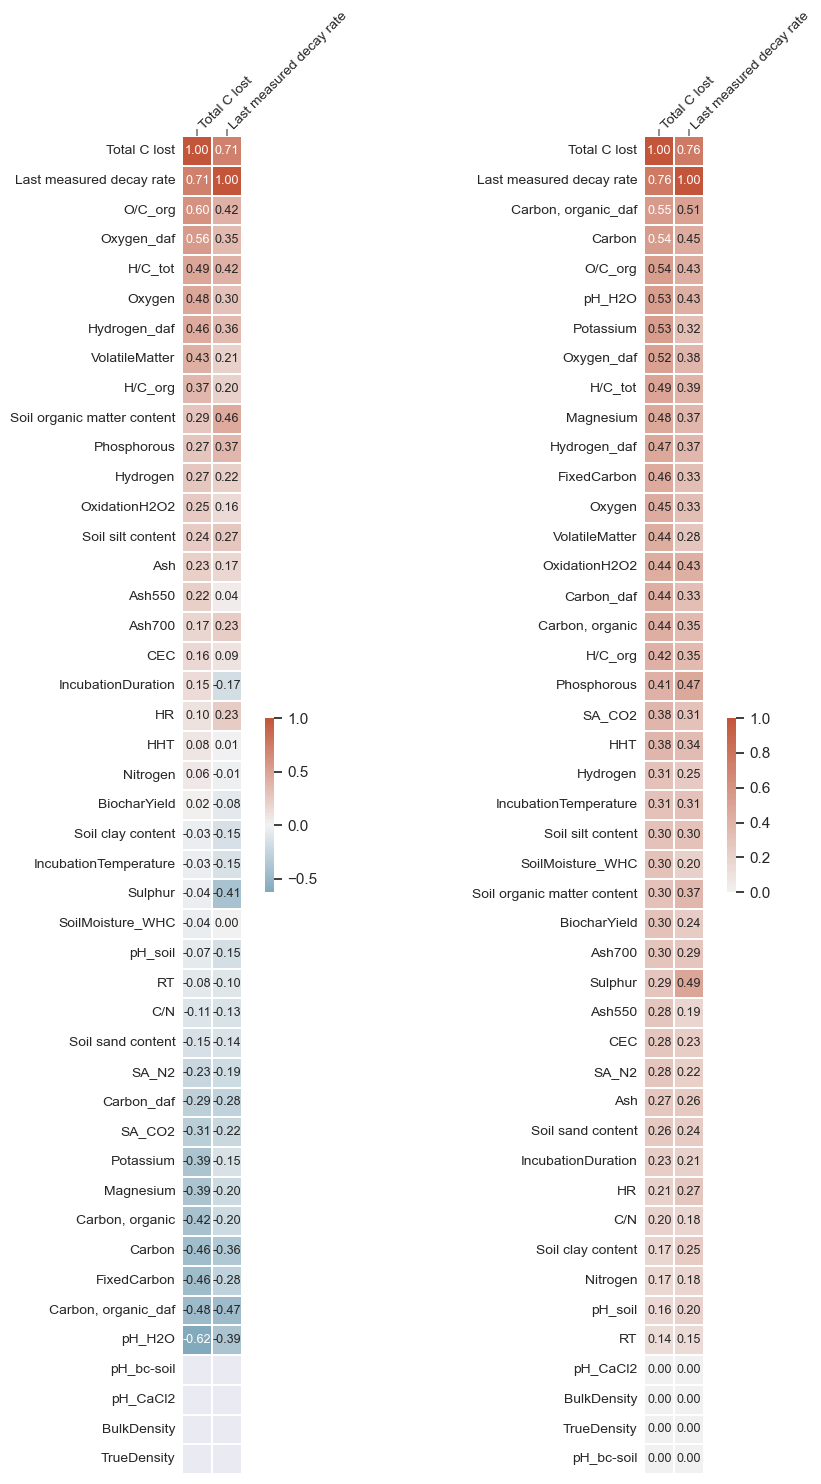

In [62]:
%matplotlib inline
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 15))
    axl = ax.ravel()
    # first corr
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    reordered_corr = corr[['Total C lost', 'Last measured decay rate']].T.T.sort_values(by='Total C lost', ascending=False)
    sns.heatmap(reordered_corr, cmap=cmap, center=0,
                square=True, 
                linewidths=.1, linecolor='white',
                cbar_kws={"shrink": 0.13},
                annot=True, annot_kws={"size": 9}, fmt='.2f', ax=axl[0])

    axl[0].tick_params(axis='both', which='major', labelsize=10, 
                   labelbottom = False, bottom=False, top = True, labeltop=True, left=False,
                   color="grey", length=5, pad=0)

    axl[0].set_xticklabels(axl[0].get_xticklabels(), rotation=45, horizontalalignment='left', verticalalignment='baseline',
                      parse_math=True);
    
    # second dcorr
    reordered_dcorr = dcorr[['Total C lost', 'Last measured decay rate']].T.T.sort_values(by='Total C lost', ascending=False)
    sns.heatmap(reordered_dcorr, cmap=cmap, center=0,
                square=True, 
                linewidths=.1, linecolor='white',
                cbar_kws={"shrink": 0.13},
                annot=True, annot_kws={"size": 9}, fmt='.2f', ax=axl[1])

    axl[1].tick_params(axis='both', which='major', labelsize=10, 
                   labelbottom = False, bottom=False, top = True, labeltop=True, left=False,
                   color="grey", length=5, pad=0)

    axl[1].set_xticklabels(axl[1].get_xticklabels(), rotation=45, horizontalalignment='left', verticalalignment='baseline',
                      parse_math=True);

fig.tight_layout()
plt.savefig('../simulations/manuscript/FigureS13_correlation-pearson-distance-CumLossLastK-numeric.png', dpi=600, bbox_inches='tight')
plt.show()

### Selected scatter plots

In [82]:
def make_corr_scatter(df, x='HHT', y='BC_100', c='BiomassClass', m = 'PyrolysisClass', 
                      an=False, fi=None, 
                      fig=None, ax=None, saveFig=False, figsize=(6,6)):
    '''
    Plot of scatter between two columns of the passed dataframe, with options to set color and marker via other columns, and annotate each datapoint.
    ''' 
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    sns.scatterplot(data=df, x=x, y=y,
                    style=m, hue=c, palette=sns.color_palette("Set2", as_cmap=False)[:len(df[c].unique())], 
                    ax = ax, s=80)
    ax.set_xlabel(x, fontsize=14)
    ax.set_ylabel(y, fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(facecolor='white', framealpha=0.2, fontsize=8) 
    
    if an is not False:
        texts = an
        xss = list(df[x])
        yss = list(df[y])
        for i, txt in enumerate(texts):
            ax.annotate(txt, xy=(xss[i], yss[i]), xycoords="data", fontsize=6)
    
    if saveFig:
        x = x.replace("/", "")
        fig.savefig('simulations/scatter-'+y+'---'+x+'.png', dpi=300, bbox_inches='tight')

In [83]:
df.columns

Index(['AuthorDate', 'BiomassClass', 'PyrolysisClass', 'HHT', 'RT', 'HR',
       'Soil clay content', 'Soil sand content', 'Soil silt content',
       'Soil organic matter content', 'SoilMoisture_WHC', 'pH_soil',
       'pH_bc-soil', 'LabField', 'IncubationTemperature', 'IncubationDuration',
       'ApplicationRate', 'Ash550', 'Ash700', 'Carbon', 'Carbon, organic',
       'Hydrogen', 'Nitrogen', 'Sulphur', 'Oxygen', 'Magnesium', 'Potassium',
       'Phosphorous', 'H/C_org', 'H/C_tot', 'O/C_org', 'C/N', 'pH_H2O',
       'pH_CaCl2', 'CEC', 'SA_N2', 'SA_CO2', 'FixedCarbon', 'VolatileMatter',
       'ParticleSize', 'BulkDensity', 'TrueDensity', 'OxidationH2O2',
       'BiocharYield', 'δ ¹³C biochar', 'δ ¹³C soil', 'Ash', 'Carbon_daf',
       'Carbon, organic_daf', 'Hydrogen_daf', 'Oxygen_daf', 'Total C lost',
       'Last measured decay rate'],
      dtype='object')

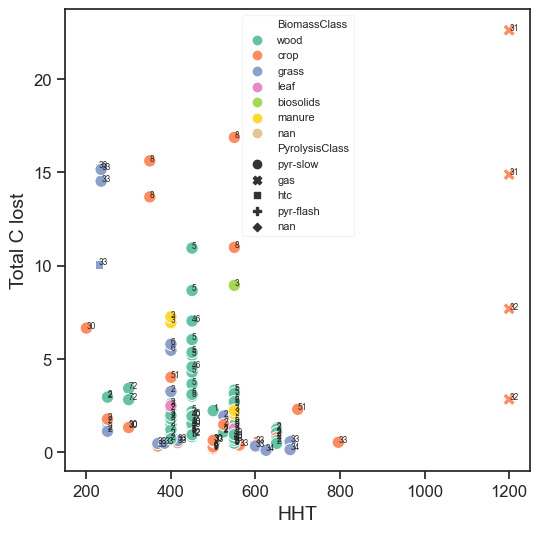

In [84]:
with sns.axes_style("ticks"):
    make_corr_scatter(df, y='Total C lost', x='HHT', an=list(metadata.loc[df.index,'ID_art']), saveFig=False)

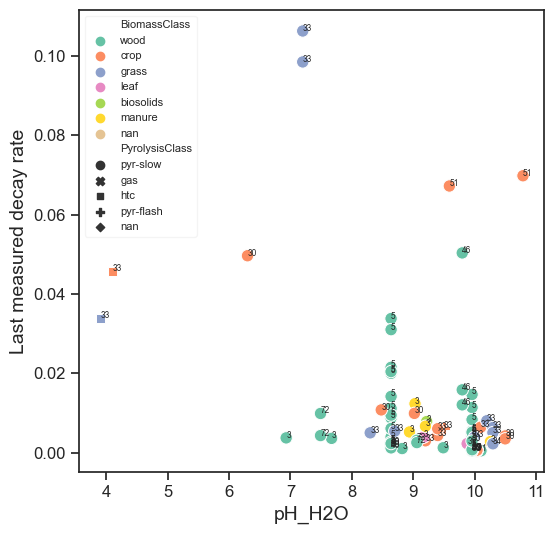

In [85]:
with sns.axes_style("ticks"):
    make_corr_scatter(df, y='Last measured decay rate', x='pH_H2O', an=list(metadata.loc[df.index,'ID_art']), saveFig=False)

### Principal component analysis

In [63]:
# used
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, explained_variance_score

# for later
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

In [64]:
fp = '../biocharStability/database/biochar_incubation_database_2022-03-22_live.xlsx'
metadata, schema, metadata_column_sets = bs.load_metadata(filepath=fp)

Metadata loaded, with 187 rows


303 remaining nans, in various columns
107 remaining nans, in various columns
Strategy for: SoilMoisture_WHC
	Mode: 0.6 will be replaced in 4 rows
Strategy for: pH_soil
	Mode: na will be replaced in 12 rows
Strategy for: pH_H2O
	Mode: na will be replaced in 6 rows
droping columns: 'Ash550', 'Ash700', keeping only Ash
droping columns: 'Carbon', 'Carbon, organic', 'Hydrogen' 'Oxygen', Nitrogen, keeping only daf - dry as free equivalents
droping 2 columns: 'H/C_org', 'H/C_tot', keeping only H/C_all
286 remaining nans, in various columns, filled with mode


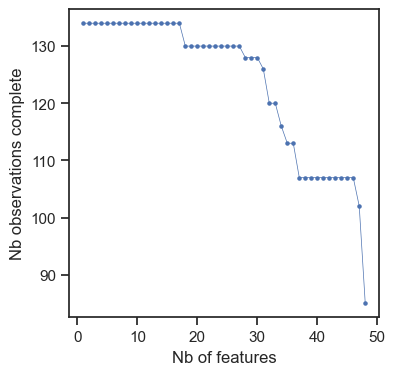

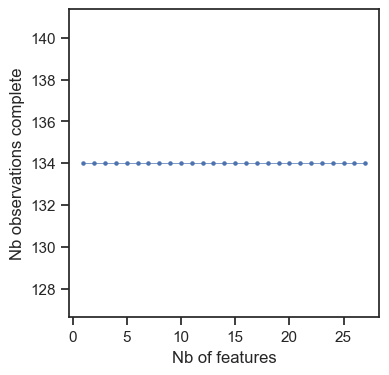

In [65]:
# numerical variables, including boolean, int, 
info_cols = ['ID_art', 'NameObs', 'Replicates','Biomass', 'Pyrolysis', 'BiomassLignin', 'Soil type',
             'SoilMoisture_Absolute', 'SoilOrigin', 'SoilGeolocation', 'TotalFluxMeasurement', 'BiocharFluxDetermination', 'OtherIncubationDescription', 'AssociatedControl',
             'Cultivated', 'ID_Lehmann2019', 'ID_Woolf2021', 'ID_Lehmann2021',
             ]
col_to_drop = ['pH_bc-soil', 'Magnesium', 'Potassium', 'Phosphorous', 'ParticleSize', 'BulkDensity',
              'TrueDensity', 'OxidationH2O2', 'BiocharYield', 'δ ¹³C biochar',
              'δ ¹³C soil', 'FixedCarbon', 'VolatileMatter', 'pH_CaCl2', 'CEC', 'SA_N2', 'SA_CO2', 'Sulphur', 'ApplicationRate',]

col_categorical = ['BiomassClass', 'PyrolysisClass', 'LabField', 'AuthorDate']

col_numerical = ['HHT', 'RT', 'HR', 'Soil clay content', 'Soil sand content', 'Soil silt content', 'Soil organic matter content',
                'SoilMoisture_WHC', 'pH_soil', 'IncubationTemperature', 'IncubationDuration', 
                'Ash550', 'Ash700', 'Carbon', 'Carbon, organic', 'Hydrogen', 'Nitrogen',
                'Oxygen', 'H/C_org', 'H/C_tot', 'O/C_org', 'C/N', 'pH_H2O',
                ]

df = metadata.copy(deep=True)
df.drop(info_cols, axis=1, inplace=True)

# total carbon loss
cum_loss = []
last_measured_time = []
for o in metadata.index:
    try:
        time,closs = bs.select_timeseries(o, data, col_to_plot='C_bc_loss_rel', factor=100)
        cum_loss.append(closs[-1])
        last_measured_time.append(time[-1])
    except Exception:
        #print("data missing for: ", o)
        cum_loss.append(np.nan)
        last_measured_time.append(np.nan)

df['Total C lost'] = cum_loss

# last measured decay rate and time for each observation
cum_loss = []
last_measured_time = []
for o in metadata.index:
    try:
        time,closs = bs.select_timeseries(o, data, col_to_plot='k_bc_rel0', factor=365)
        cum_loss.append(closs[-1])
        last_measured_time.append(time[-1])
    except Exception:
        #print("data missing for: ", o)
        cum_loss.append(np.nan)
        last_measured_time.append(np.nan)

df['Last measured decay rate'] = cum_loss

# exclude non-biochar obsevations
#df = df[df['PyrolysisClass'] != 'no-treat']

# removing observations without incubation data
obs_with_data = data['ID_obs'].unique() # altough 2 obs without important series
to_drop = list(set(metadata.index) - (set(obs_with_data) - {39, 111}) )
X = df.drop(to_drop, inplace=False, axis=0)
opf, opf_x, opf_y = bs.obs_per_feat(X)
print(X.isna().sum().sum(), "remaining nans, in various columns")

# droping columns with too few data
X.drop(col_to_drop, axis=1, inplace=True)
print(X.isna().sum().sum(), "remaining nans, in various columns")

# 'SoilMoisture_WHC' : bridge gap, with mode; rationale: most lab experiment used 60%, if different, it is usually reported
c = 'SoilMoisture_WHC'
print("Strategy for:", c)
print("\tMode:", X[c].mode()[0], "will be replaced in", X[c].isna().sum(), "rows")
X[c].fillna(X[c].mode()[0], inplace=True)
# 'SoilMoisture_WHC': for field experiments, rainfall as str is recorded > to replace by the mode
c = 'SoilMoisture_WHC'
X[c].replace(['788.4 mm/yr', '1109.4 mm/yr'], X[c].mode()[0], inplace=True)

# 'pH_soil' : bridge gap, with mode; rationale: for Zimmerman (sand), 1 of Kuzyakov (loess), 
c = 'pH_soil'
print("Strategy for:", c)
print("\tMode:", X[c].mode()[0], "will be replaced in", X[c].isna().sum(), "rows")
X[c].fillna(X[c].mode()[0], inplace=True)

# 'pH_H2O' :  biochar pH in water, bridge gap, with mode; rationale: for Zimmerman  
c = 'pH_H2O'
print("Strategy for:", c)
print("\tMode:", X[c].mode()[0], "will be replaced in", X[c].isna().sum(), "rows")
X[c].fillna(X[c].mode()[0], inplace=True)

# filling C_org with C_total if missing
X['Carbon, organic'] = X['Carbon, organic'].fillna(X['Carbon'], inplace=False)

# adding, dry ash-free elemental contents (after filling C_org)
dafs = ['Carbon', 'Carbon, organic', 'Hydrogen', 'Oxygen', 'Nitrogen']
for d in dafs:
    X = bs.dry2daf(X, x=d, ash='Ash')
# droping correlated variables: 
X.drop(['Ash550', 'Ash700', 'Carbon', 'Carbon, organic', 'Hydrogen', 'Oxygen', 'Nitrogen'], axis=1, inplace=True)
print("droping columns: 'Ash550', 'Ash700', keeping only Ash")
print("droping columns: 'Carbon', 'Carbon, organic', 'Hydrogen' 'Oxygen', Nitrogen, keeping only daf - dry as free equivalents")

# H/C_all: merge, with strategy: H/C_org if existing, otherwise, H/C_tot; likewise for C, C_org
X['H/C_all'] = X['H/C_org'].fillna(X['H/C_tot'], inplace=False)
X.drop(['H/C_org', 'H/C_tot'], axis=1, inplace=True)
print("droping 2 columns: 'H/C_org', 'H/C_tot', keeping only H/C_all")

# fill all the rest with mode; slightly brutal
print(X.isna().sum().sum(), "remaining nans, in various columns, filled with mode")
X.fillna(X.mode().loc[0,:], inplace=True)

opf, opf_x, opf_y = bs.obs_per_feat(X)


In [66]:
X.columns

Index(['AuthorDate', 'BiomassClass', 'PyrolysisClass', 'HHT', 'RT', 'HR',
       'Soil clay content', 'Soil sand content', 'Soil silt content',
       'Soil organic matter content', 'SoilMoisture_WHC', 'pH_soil',
       'LabField', 'IncubationTemperature', 'IncubationDuration', 'O/C_org',
       'C/N', 'pH_H2O', 'Total C lost', 'Last measured decay rate', 'Ash',
       'Carbon_daf', 'Carbon, organic_daf', 'Hydrogen_daf', 'Oxygen_daf',
       'Nitrogen_daf', 'H/C_all'],
      dtype='object')

#### PCA on All numerics

In [67]:
XY = X.drop(labels=['BiomassClass', 'PyrolysisClass', 'LabField', 'AuthorDate' #'RT', 'HR',
               #'IncubationTemperature', 'IncubationDuration','pH_H2O'
               ], axis=1, inplace=False)

XY = XY.drop(labels=[ 'Total C lost', 'Last measured decay rate',], axis=1, inplace=False)

In [68]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(XY)
categorical_columns = categorical_columns_selector(XY)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore") # Here, could do a LabelEncoder() as well
numerical_preprocessor = StandardScaler() #StandardScaler() # RobustScaler() can also do robustscaler, dealing with outliers differently

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

In [69]:
print('Variables in this PCA: \n', XY.columns)

Variables in this PCA: 
 Index(['HHT', 'RT', 'HR', 'Soil clay content', 'Soil sand content',
       'Soil silt content', 'Soil organic matter content', 'SoilMoisture_WHC',
       'pH_soil', 'IncubationTemperature', 'IncubationDuration', 'O/C_org',
       'C/N', 'pH_H2O', 'Ash', 'Carbon_daf', 'Carbon, organic_daf',
       'Hydrogen_daf', 'Oxygen_daf', 'Nitrogen_daf', 'H/C_all'],
      dtype='object')


In [70]:
model_PCA = make_pipeline(preprocessor, PCA(n_components=3))
_ = model_PCA.fit(XY)
projected = model_PCA.fit_transform(XY)

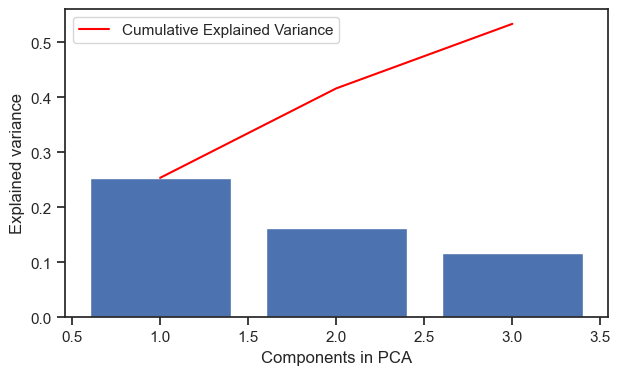

In [71]:
%matplotlib inline

# based on: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html 
expl_var = model_PCA.named_steps['pca'].explained_variance_ratio_

fig, ax = plt.subplots(figsize=(7,4))
ax.bar(range(1,len(expl_var)+1),expl_var )

ax.plot(np.arange(len(expl_var))+1, expl_var.cumsum(), c='red', label="Cumulative Explained Variance")
plt.legend(loc='upper left')

plt.xlabel('Components in PCA')
plt.ylabel('Explained variance');

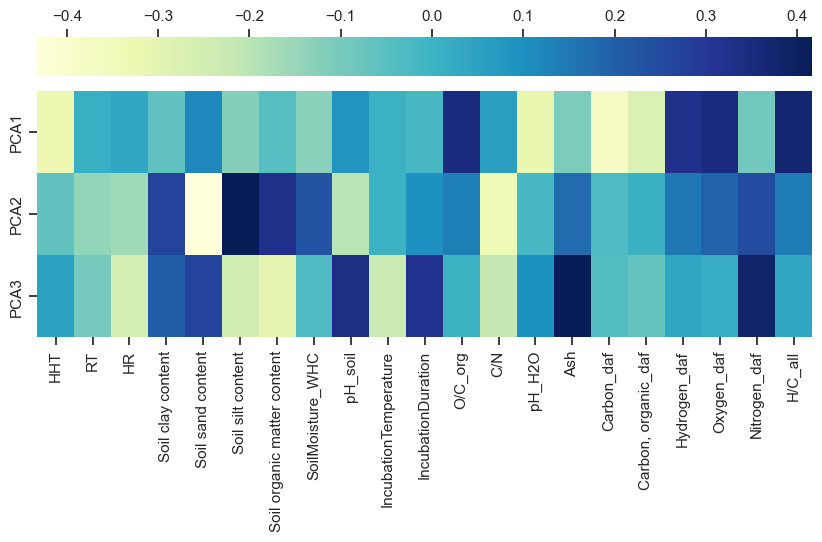

In [72]:
transformedfeatures = list(model_PCA.named_steps['columntransformer'].get_feature_names_out())
transformedfeatures = [x.removeprefix("one-hot-encoder__") for x in transformedfeatures]
transformedfeatures = [x.removeprefix("standard_scaler__") for x in transformedfeatures]
#transformedfeatures
pcamodel = model_PCA.named_steps['pca']

fig, ax = plt.subplots(figsize=(10,4))
ax = sns.heatmap(pcamodel.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pcamodel.n_components_+1)],
                 xticklabels=transformedfeatures,
                 cbar_kws={"orientation": "horizontal", "location":"top"})
#ax.set_aspect("equal")

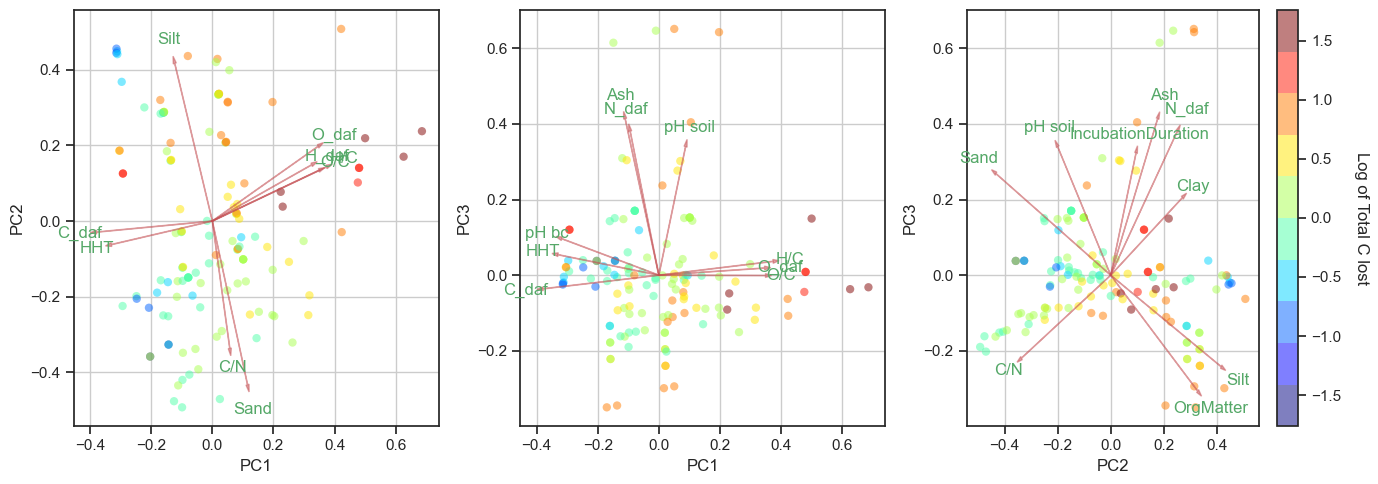

In [73]:
fig, ax = plt.subplots(1,3, figsize=(14, 5))
a=9
Y= np.log10(X['Total C lost'])
#
transformedfeatures_renamed = ['HHT', 'RT', 'HR', 'Clay', 'Sand', 'Silt','OrgMatter','WHC',
 'pH soil',
 'IncubationTemperature',
 'IncubationDuration',
 'O/C',
 'C/N',
 'pH bc',
 #'Total C lost',
 #'Last measured decay rate',
 'Ash',
 'C_daf',
 'C_org_daf',
 'H_daf',
 'O_daf',
 'N_daf',
 'H/C']

#row 1
bs.plot_pca_biplot(projected, pcamodel.components_, transformedfeatures_renamed, 0, 1, a, Y, fig=fig, ax=ax[0])
bs.plot_pca_biplot(projected, pcamodel.components_, transformedfeatures_renamed, 0, 2, a, Y, fig=fig, ax=ax[1])
bs.plot_pca_biplot(projected, pcamodel.components_, transformedfeatures_renamed, 1, 2, a, Y, fig=fig, ax=ax[2],
                  cbartxt='Log of Total C lost')
[ ax[i].grid(axis='both') for i in [0,1,2]]

fig.tight_layout()
#fig.savefig('simulations/PCA.png', dpi=300)

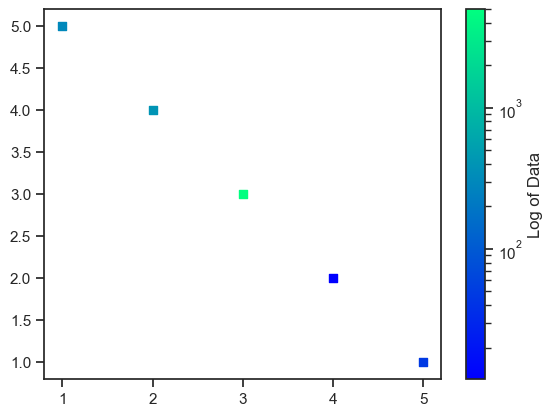

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
fig = plt.figure(1)

time = 2 

x = [1, 2, 3, 4, 5]
y = [5, 4, 3, 2, 1]

multi_array = np.asarray([[1, 1, 10, 100, 1000], [10000, 1000, 100, 10, 1], [300, 400, 5000, 12, 47]])

for counter in np.arange(0, 5):
    s = plt.scatter(x[counter], y[counter], c = multi_array[time, counter], cmap = 'winter',
                    norm = clrs.LogNorm(vmin=multi_array[time].min(), vmax=multi_array[time].max()), marker = 's', )

cb = plt.colorbar(s)
cb.set_label('Log of Data')

plt.show()

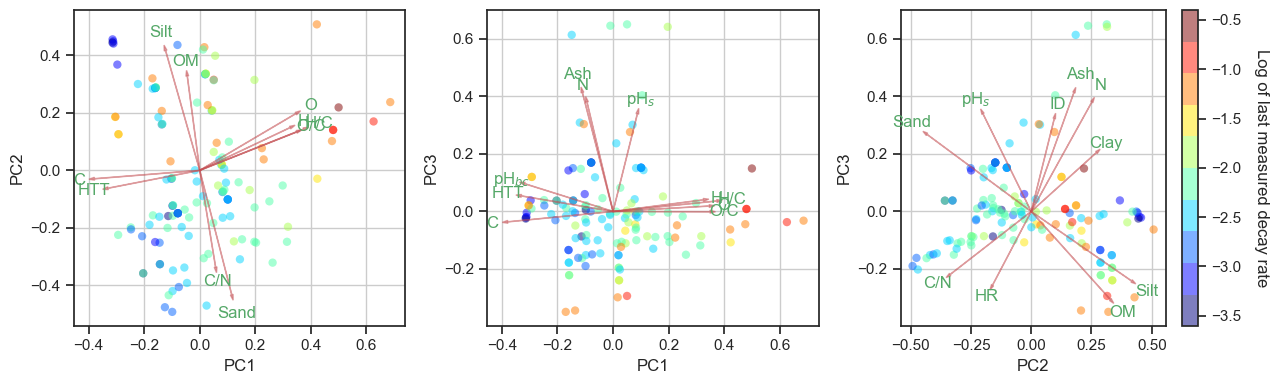

In [75]:
fig, ax = plt.subplots(1,3, figsize=(13, 4))
a=10
Y= np.log10(X['Last measured decay rate'])

transformedfeatures_renamed = ['HTT', 'RT', 'HR', 'Clay', 'Sand', 'Silt','OM','WHC',
 r'pH$_{s}$',
 r'T$_{inc}$',
 'ID',
 'O/C',
 'C/N',
 r'pH$_{bc}$',
 #'Total C lost',
 #'Last measured decay rate',
 'Ash',
 'C',
 'C$_{org}$',
 'H',
 'O',
 'N', 
 'H/C'] # variables here in same order as in XY.columns

#row 1
bs.plot_pca_biplot(projected, pcamodel.components_, transformedfeatures_renamed, 0, 1, a, Y, fig=fig, ax=ax[0])
bs.plot_pca_biplot(projected, pcamodel.components_, transformedfeatures_renamed, 0, 2, a, Y, fig=fig, ax=ax[1])
bs.plot_pca_biplot(projected, pcamodel.components_, transformedfeatures_renamed, 1, 2, a, Y, fig=fig, ax=ax[2],
                  cbartxt='Log of last measured decay rate')
[ ax[i].grid(axis='both') for i in [0,1,2]]

fig.tight_layout()
fig.savefig('../simulations/manuscript/Figure5_PCA_allnumerics_lastmeasureddecay.png', dpi=600)

#### PCA on non-correlated subset

In [29]:
# drop categorical
XY = X.drop(labels=['BiomassClass', 'PyrolysisClass', 'LabField', 'AuthorDate' #'RT', 'HR',
               #'IncubationTemperature', 'IncubationDuration','pH_H2O'
               ], axis=1, inplace=False)

# keep only subset of columns
FiveCols = ['Soil clay content', 'SoilMoisture_WHC', 'Ash', 'Nitrogen_daf', 'H/C_all', 'pH_H2O', 'RT']
XY = XY[FiveCols].copy()

In [30]:
XY.corr(method='pearson', numeric_only=True)

Soil clay content  SoilMoisture_WHC       Ash  \
Soil clay content           1.000000          0.116487  0.181030   
SoilMoisture_WHC            0.116487          1.000000  0.307290   
Ash                         0.181030          0.307290  1.000000   
Nitrogen_daf                0.252049          0.318917  0.733571   
H/C_all                    -0.110789         -0.261375 -0.007538   
pH_H2O                      0.200455          0.332273  0.210993   
RT                         -0.207715         -0.028137 -0.086253   

                   Nitrogen_daf   H/C_all    pH_H2O        RT  
Soil clay content      0.252049 -0.110789  0.200455 -0.207715  
SoilMoisture_WHC       0.318917 -0.261375  0.332273 -0.028137  
Ash                    0.733571 -0.007538  0.210993 -0.086253  
Nitrogen_daf           1.000000  0.011523  0.230047 -0.090798  
H/C_all                0.011523  1.000000 -0.725775 -0.024031  
pH_H2O                 0.230047 -0.725775  1.000000 -0.040577  
RT                    -0.090798 -0.024031 -0.040577  1.000000

In [31]:
print('Variables in this PCA: \n', XY.columns)

Variables in this PCA: 
 Index(['Soil clay content', 'SoilMoisture_WHC', 'Ash', 'Nitrogen_daf',
       'H/C_all', 'pH_H2O', 'RT'],
      dtype='object')


In [32]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(XY)
categorical_columns = categorical_columns_selector(XY)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore") # Here, could do a LabelEncoder() as well
numerical_preprocessor = StandardScaler() #StandardScaler() # RobustScaler() can also do robustscaler, dealing with outliers differently

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

In [33]:
model_PCA = make_pipeline(preprocessor, PCA(n_components=3))
_ = model_PCA.fit(XY)
projected = model_PCA.fit_transform(XY)

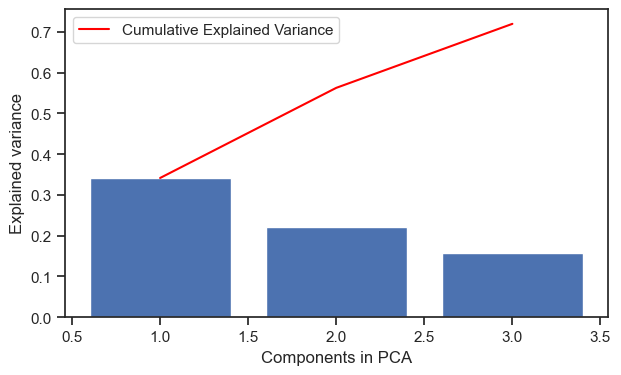

In [34]:
%matplotlib inline

# based on: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html 
expl_var = model_PCA.named_steps['pca'].explained_variance_ratio_

fig, ax = plt.subplots(figsize=(7,4))
ax.bar(range(1,len(expl_var)+1),expl_var )

ax.plot(np.arange(len(expl_var))+1, expl_var.cumsum(), c='red', label="Cumulative Explained Variance")
plt.legend(loc='upper left')

plt.xlabel('Components in PCA')
plt.ylabel('Explained variance');

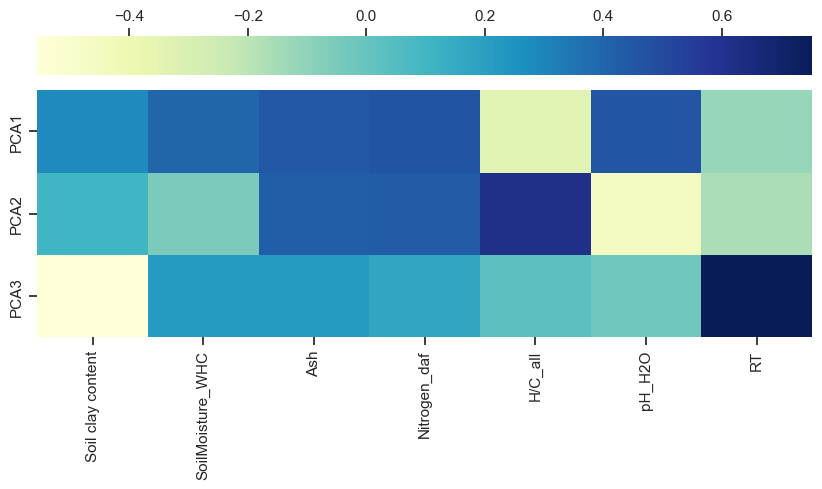

In [35]:
transformedfeatures = list(model_PCA.named_steps['columntransformer'].get_feature_names_out())
transformedfeatures = [x.removeprefix("one-hot-encoder__") for x in transformedfeatures]
transformedfeatures = [x.removeprefix("standard_scaler__") for x in transformedfeatures]
#transformedfeatures
pcamodel = model_PCA.named_steps['pca']

fig, ax = plt.subplots(figsize=(10,4))
ax = sns.heatmap(pcamodel.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pcamodel.n_components_+1)],
                 xticklabels=transformedfeatures,
                 cbar_kws={"orientation": "horizontal", "location":"top"})
#ax.set_aspect("equal")

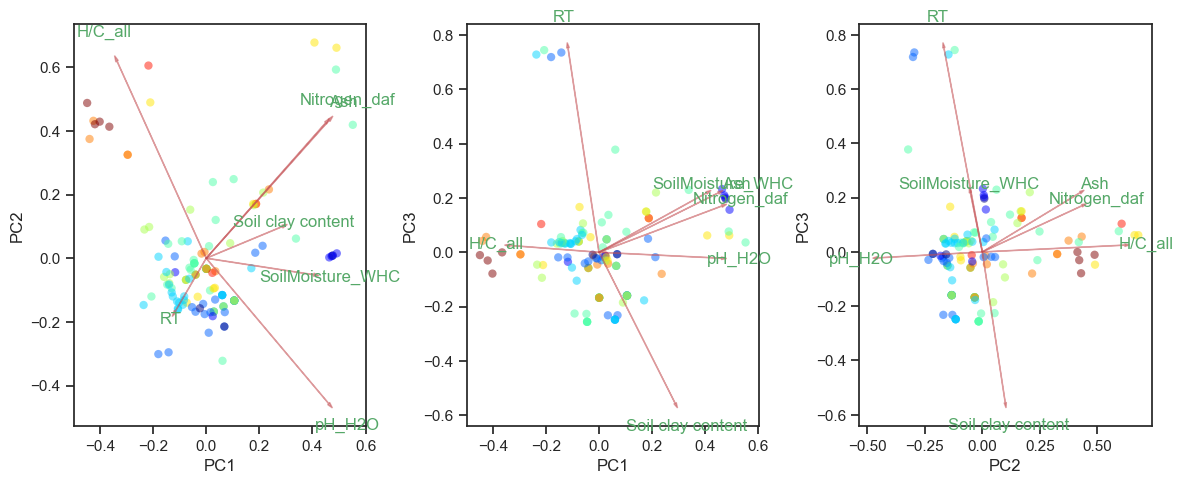

In [37]:
fig, ax = plt.subplots(1,3, figsize=(12, 5))
a=10
Y= np.log(X['Total C lost'])
#row 1
bs.plot_pca_biplot(projected, pcamodel.components_, transformedfeatures, 0, 1, a, Y, fig=fig, ax=ax[0])
bs.plot_pca_biplot(projected, pcamodel.components_, transformedfeatures, 0, 2, a, Y, fig=fig, ax=ax[1])
bs.plot_pca_biplot(projected, pcamodel.components_, transformedfeatures, 1, 2, a, Y, fig=fig, ax=ax[2])


fig.tight_layout(w_pad=0, h_pad=0.2)
#fig.savefig('simulations/PCA.png', dpi=300)

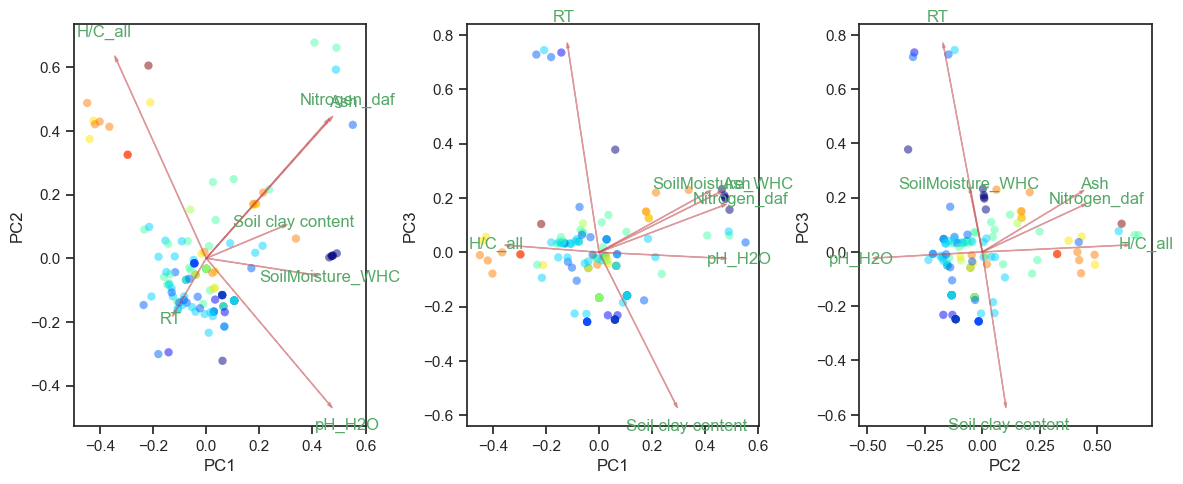

In [38]:
fig, ax = plt.subplots(1,3, figsize=(12, 5))
a=10
Y= np.log(X['Last measured decay rate'])
#row 1
bs.plot_pca_biplot(projected, pcamodel.components_, transformedfeatures, 0, 1, a, Y, fig=fig, ax=ax[0])
bs.plot_pca_biplot(projected, pcamodel.components_, transformedfeatures, 0, 2, a, Y, fig=fig, ax=ax[1])
bs.plot_pca_biplot(projected, pcamodel.components_, transformedfeatures, 1, 2, a, Y, fig=fig, ax=ax[2])


fig.tight_layout(w_pad=0, h_pad=0.2)
#fig.savefig('simulations/PCA.png', dpi=300)

### FAMD: Factorial Analysis of Mixed Data

Suited for mix of categorical and numerical vairables
* https://github.com/MaxHalford/prince
* https://maxhalford.github.io/prince/famd/

* Guide for interpretation: https://rpubs.com/nchelaru/famd

In [206]:
X.columns

Index(['AuthorDate', 'BiomassClass', 'PyrolysisClass', 'HHT', 'RT', 'HR',
       'Soil clay content', 'Soil sand content', 'Soil silt content',
       'Soil organic matter content', 'SoilMoisture_WHC', 'pH_soil',
       'LabField', 'IncubationTemperature', 'IncubationDuration', 'O/C_org',
       'C/N', 'pH_H2O', 'Total C lost', 'Last measured decay rate', 'Ash',
       'Carbon_daf', 'Carbon, organic_daf', 'Hydrogen_daf', 'Oxygen_daf',
       'Nitrogen_daf', 'H/C_all'],
      dtype='object')

In [207]:
XY = X.drop(['Total C lost', 'Last measured decay rate'], axis=1)

In [230]:
categorical = ['AuthorDate', 'BiomassClass', 'PyrolysisClass', 'LabField', ]
for c in categorical:
    XY[c] = XY[c].astype('category')

In [180]:
import prince

In [233]:
famd = prince.FAMD(
    n_components=7,
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"  # same parameter as sklearn.preprocessing.OneHotEncoder
)
famd = famd.fit(XY)

Interpertation guide: 

An eigenvalue >1 indicates that the PD accounts for more variance than one of the original variables in standardized data (N.B. This holds true only when the data are standardized.). This is commonly used as a cutoff point for which PDs are retained to be used in further analysis. 

The scree plot indicates that only the first four PDs account for more variance than each of the original variables, whereas the one on the right shows that together they account for only 46.7% of the total variance in the data set. This suggests that this dataset is quite complex, potentially due to 1) the relationships between the variables being non-linear, and/or 2) some factors (variables) that can account for variance in this dataset are not included in this analysis.

In [234]:
famd.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0              8.157        11.49%                     11.49%
1              6.125         8.63%                     20.12%
2              5.617         7.91%                     28.03%
3              4.991         7.03%                     35.06%
4              4.098         5.77%                     40.83%
5              3.663         5.16%                     45.99%
6              2.928         4.12%                     50.11%

In [235]:
famd.column_coordinates_

component                           0         1         2         3         4  \
variable                                                                        
HHT                          0.671955  0.021328  0.001575  0.152021  0.001359   
RT                           0.003633  0.006880  0.027892  0.040438  0.009827   
HR                           0.006440  0.013675  0.108896  0.021563  0.083635   
Soil clay content            0.015276  0.113531  0.315497  0.100692  0.171285   
Soil sand content            0.188364  0.004980  0.034127  0.483385  0.092543   
Soil silt content            0.282602  0.057618  0.030676  0.349071  0.036349   
Soil organic matter content  0.019670  0.004656  0.036643  0.479577  0.071724   
SoilMoisture_WHC             0.239743  0.011677  0.006256  0.166723  0.026970   
pH_soil                      0.148764  0.067004  0.174199  0.125658  0.012020   
IncubationTemperature        0.027951  0.194760  0.048569  0.041487  0.025331   
IncubationDuration           0.000091  0.066847  0.460605  0.000690  0.043172   
O/C_org                      0.230314  0.243144  0.004614  0.010492  0.022310   
C/N                          0.075656  0.042994  0.119723  0.215134  0.001466   
pH_H2O                       0.256872  0.327580  0.009477  0.005217  0.030332   
Ash                          0.203470  0.087427  0.418739  0.000121  0.033842   
Carbon_daf                   0.530042  0.089743  0.009477  0.000622  0.139931   
Carbon, organic_daf          0.436301  0.020016  0.008918  0.014767  0.000984   
Hydrogen_daf                 0.180868  0.387229  0.021745  0.001673  0.017822   
Oxygen_daf                   0.205066  0.292921  0.014450  0.031448  0.029922   
Nitrogen_daf                 0.148290  0.036761  0.444911  0.039087  0.053550   
H/C_all                      0.333029  0.437440  0.015638  0.011434  0.059401   
AuthorDate                   0.783315  0.671490  0.843799  0.915932  0.849260   
BiomassClass                 0.206362  0.443124  0.792142  0.114730  0.397147   
LabField                     0.352568  0.116843  0.010232  0.148886  0.164131   
PyrolysisClass               0.634593  0.564587  0.006216  0.175750  0.157443   

component                               5         6  
variable                                             
HHT                          4.169568e-03  0.024798  
RT                           3.907661e-02  0.009033  
HR                           3.728219e-01  0.056698  
Soil clay content            9.406498e-03  0.005967  
Soil sand content            3.334771e-02  0.006989  
Soil silt content            3.572421e-02  0.024349  
Soil organic matter content  1.150238e-02  0.014153  
SoilMoisture_WHC             1.083990e-01  0.108937  
pH_soil                      2.435158e-10  0.000278  
IncubationTemperature        3.263453e-02  0.005840  
IncubationDuration           6.623659e-02  0.039317  
O/C_org                      3.321619e-02  0.026925  
C/N                          3.604956e-02  0.030077  
pH_H2O                       1.229800e-03  0.087637  
Ash                          2.117962e-02  0.000961  
Carbon_daf                   2.428022e-03  0.000037  
Carbon, organic_daf          2.103838e-02  0.056566  
Hydrogen_daf                 5.513895e-02  0.007026  
Oxygen_daf                   9.377069e-02  0.051795  
Nitrogen_daf                 2.264416e-02  0.007997  
H/C_all                      2.743676e-02  0.001693  
AuthorDate                   8.843942e-01  0.950582  
BiomassClass                 3.804039e-01  0.016692  
LabField                     8.686436e-04  0.141800  
PyrolysisClass               4.569490e-02  0.072732

In [237]:
famd.plot(
    XY,
    x_component=0,
    y_component=1,
    color_by= 'BiomassClass',
)

ValueError: BiomassClass encoding field is specified without a type; the type cannot be inferred because it does not match any column in the data.

alt.LayerChart(...)

In [200]:
famd.plot(
    X,
    x_component=0,
    y_component=2
)

alt.LayerChart(...)

In [192]:
famd.plot(
    X,
    x_component=1,
    y_component=2
)

alt.LayerChart(...)

## Conclusions